**<h1>Problem Statement</h1>**

<li><b>According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally.</b></li>

<li><b>Stroke is responsible for approximately 11% of total deaths in the world</b></li>

<li><b>The dataset is provided to predict whether a patient is likely to get stroke or not on the basis of given input parameters</b></li>

<li><b>Each row in the data provides relavant information about the patient.</b></li>

<li><b>After going through the context of datasets, we can say that it is a binary classification problem</b></li>

<li><b>We have to make prediction on the target variable STROKE</b></li>

<li><b>Finally, we have to build a model to get the best prediction on the stroke variable</b></li>





___________________________________________________________



___________________________________________________________

**<h4>Importing all necessary libraries</h4>**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.metrics import classification_report,accuracy_score,recall_score,confusion_matrix,roc_auc_score,precision_score,f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, SelectFromModel, f_classif


from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier


<h4><b>Loading the dataset in a pandas dataframe</b></h4>

In [2]:
dataset = pd.read_csv('heartstroke-data.csv')
print(dataset.shape)
dataset.head()

(5110, 12)


id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


**<h1>Insights From First Glance</h1>**

<li><b>In our dataset, we have both numerical and categorical variables.</b></li>

<li><b>There are 5110 rows and 12 columns in the dataset.</b></li>

<li><b>There are seven numerical variables and 5 categorical variables.</b></li>

<li><b>The most important one to look for is our target variable 'stroke'.</b></li>

<li><b>'Stroke' is detected as an integer, not as an object.</b></li>

<li><b>Target variable is coded as 1 for positive cases (has a stroke) and 0 for negative cases (does not have a stroke).</b></li>

<li><b>Both 'hypertension' and 'heart_disease" are detected as an integer, not as an object.</b></li>

<li><b>From the data definition part, they are coded as 1 for the positive cases (has hypertension/heart disease)</b></li>

<li><b>And 0 for the negative cases (does not have hypertension/heart disease)</b></li>

<li><b>We don't need to change them, but it is good to see and be aware of them</b></li>

<li><b>We have 5 categorical variables, which we have to encode as numerical</li></b>

<li><b>We can also see that there are missing values in the 'bmi' column</b></li>


**<h1>Exploratory Data Analysis</h1>**

**<h4>Checking Missing Values</h4>**

In [4]:
def check_missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = ((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values


In [5]:
check_missing_values(dataset)

Missing_Number  Missing_Percent
bmi                           201         3.933464
id                              0         0.000000
gender                          0         0.000000
age                             0         0.000000
hypertension                    0         0.000000
heart_disease                   0         0.000000
ever_married                    0         0.000000
work_type                       0         0.000000
Residence_type                  0         0.000000
avg_glucose_level               0         0.000000
smoking_status                  0         0.000000
stroke                          0         0.000000

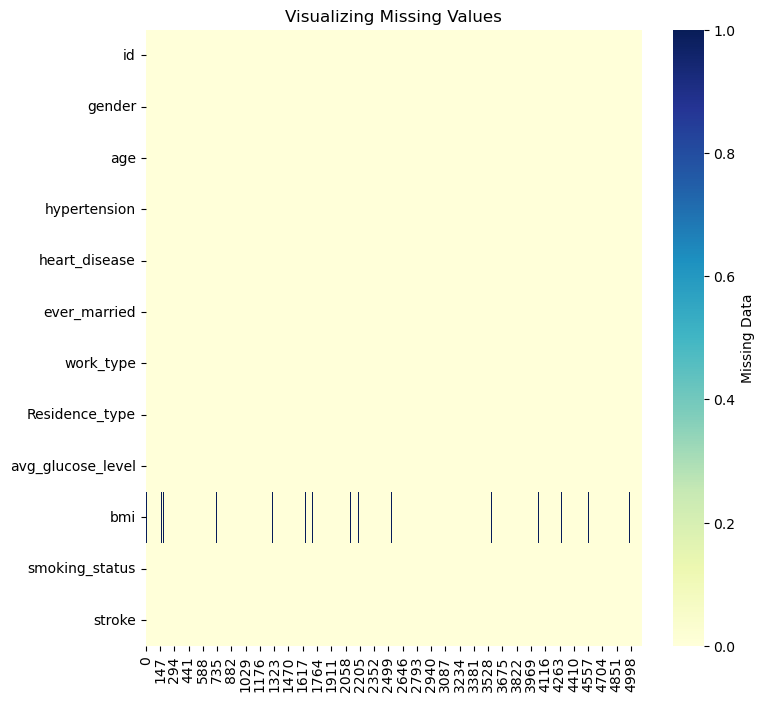

In [6]:
plt.figure(figsize=(8,8))
plt.title('Visualizing Missing Values')
sns.heatmap(dataset.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.show()

<li><b>We have 201 missing values in 'bmi' column which is 4% of the whole datasets</li></b>

<li><b>It seems like we have random missing values.. There is no pattern in missing values</b></li>

<li><b>We will handle the missing values after encoding every categorical variables to numerical variables during the model preparation phase.</b></li>

<li><b>Let's see our categorical and numerical values separately</b></li>



**<h3>Categorical Variables and Univariate Analysis</h3>**



In [7]:
def categories_count (df,col_name):
    count = df[col_name].value_counts().tolist()
    categories = df[col_name].value_counts().index.tolist()
    count_df = pd.DataFrame({'Column_Name' : categories, 'Count' : count})
    return count_df

In [8]:
def univariate_barplot(df,xlabel,ylabel="Frequency"):
  ax=plt.figure(figsize=(6,6))
  ax = sns.barplot()
  ax = sns.barplot(x='Column_Name',y='Count',data = df)
  ax.set_title("Distribution of {} in the dataset".format(xlabel))
  ax.set(xlabel=xlabel, ylabel=ylabel)
  total = df['Count'].sum()
  for p in ax.patches:
    height = p.get_height()
    height_percentage = "{:.1f}%".format((100 * height)/ total)
    ax.text(p.get_x()+p.get_width()/2., height + 5,height_percentage ,ha="center")
  plt.show()

**<h5>Gender</h5>**

posx and posy should be finite values
posx and posy should be finite values


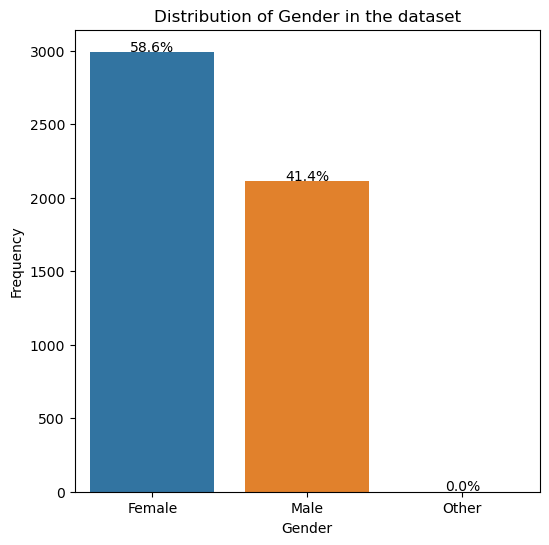

In [9]:
count_df = categories_count(dataset,'gender')
univariate_barplot(count_df,xlabel='Gender')


<li><b>We will use label encoder to encode gender column after dropping the row.</b></li> 
<li><b>58.6% of people are female and 41.4% female are males and almost 0% of people belong to other gender.</b></li>



In [10]:
dataset = dataset.loc[dataset['gender']!='Other',:]
dataset.reset_index(drop=True,inplace=True)

**<h4>ever_married</h4>**

posx and posy should be finite values
posx and posy should be finite values


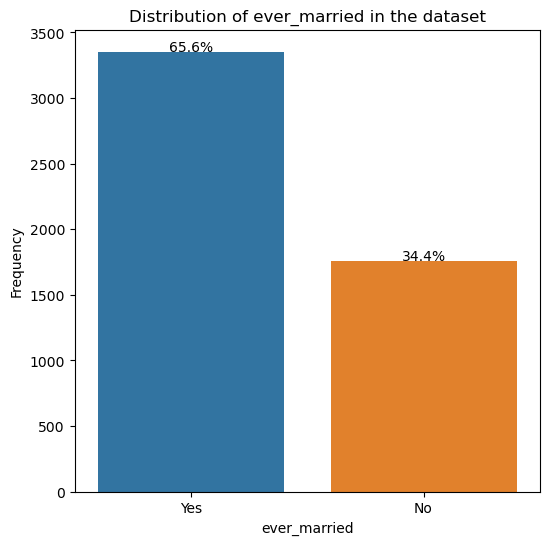

In [11]:
count_df = categories_count(dataset,'ever_married')
univariate_barplot(count_df,xlabel='ever_married')

<ul>
<li><b>This feature has two categorical values: </b></li>
<ul>
<li><b>'Yes' indicating marital status as married</b></li>
  <li><b> 'No' indicating marital status as unmarried</b></li>
</ul>
<li><b>65.6% of people are married and 34.4% of people are unmarried.</b></li>
</ul>

**<h4>Residence_type</h4>**

posx and posy should be finite values
posx and posy should be finite values


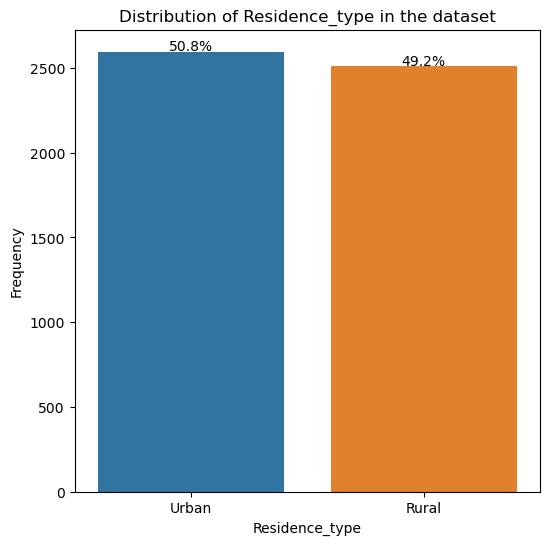

In [12]:
count_df = categories_count(dataset,'Residence_type')
univariate_barplot(count_df,xlabel='Residence_type')

<li><b>This feature has two categorical values: 1) Urban and 2) Rural </b></li>
<li><b>50.8% of people are living in Urban area whereas 49.2% of people are living in Rural areas.</b></li>


**<h4>work_type</h4>**

posx and posy should be finite values
posx and posy should be finite values


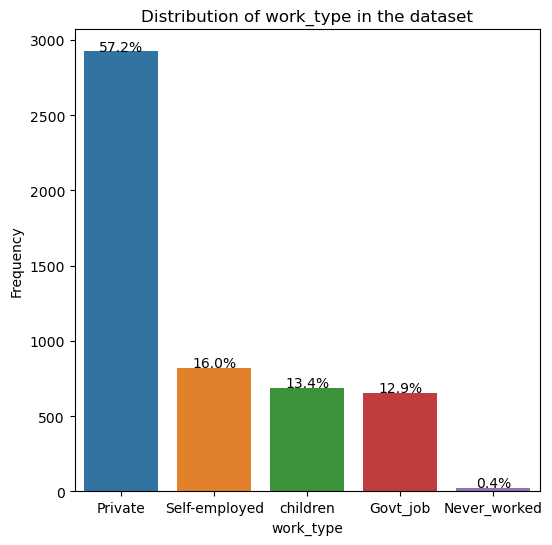

In [13]:
count_df = categories_count(dataset,'work_type')
univariate_barplot(count_df,xlabel='work_type')

<li><b>'children' does not seem to be the work_type</b></li>
<li><b>57.2 % of people work in private companies, 16 % of people are self-employed and 12.9 % of people work in government jobs</b></li>
<li><b>Whereas 13.4 % of people are children and 0.4 % of people have never worked.</b></li>
<li><b>We cannot draw meaningful conclusion about appropriate age group for certain worktypes through univariate analysis only.</b></li>
<li><b>Let's explore this feature using multivariate analysis to get more insights on the data</b></li>

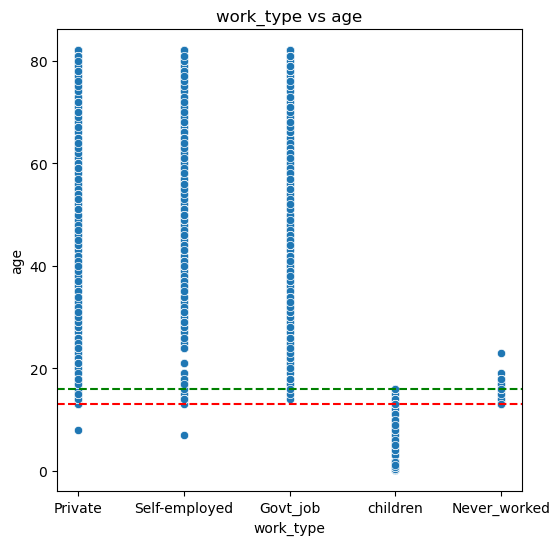

In [14]:
  ax=plt.figure(figsize=(6,6))
  ax = sns.scatterplot(x='work_type',y='age',data = dataset)
  ax.set_title('work_type vs age')
  ax.set(xlabel='work_type', ylabel='age')
  plt.axhline(y=13, c='red', linestyle='dashed')
  plt.axhline(y=16, c='green', linestyle='dashed')
  plt.show()

**<h4>Let's make some assumptions on data</h4>**

<li><b>Bivariate analysis is done to understand appropriate age group for certain work types.</b></li>

<li><b>Since, children are not allowed to work so we can change these values to Never_worked category.</b></li>

<li><b>Let's assume that people below 13 years age can not be employed for a private job as it is a minimum criteria for many different countries.</b></li>

<li><b>Let's assume that the people below 16 years of age can not be employed for a government job as it is a minimum criteria.</b></li>

<li><b>These days lots of people can be self-employed from youtube. However, the minimum age limit for youtuber is 13 years.</b></li>

<li><b>Considering this situation, let's assume that the minimum age limit for being self-employed to be 13 years.</b></li>

<li><b>Then only, we will encode these values to numerical values</b></li>

In [15]:
dataset.loc[dataset['work_type']=="children",'work_type'] = 'Never_worked'
dataset.loc[(dataset['work_type']=='Private') & (dataset['age'] < 13),"age"] = 13
dataset.loc[(dataset['work_type']=='Govt_job') & (dataset['age'] < 16),"age"] = 16
dataset.loc[(dataset['work_type']=='Self-employed') & (dataset['age'] < 13),"age"] = 13

posx and posy should be finite values
posx and posy should be finite values


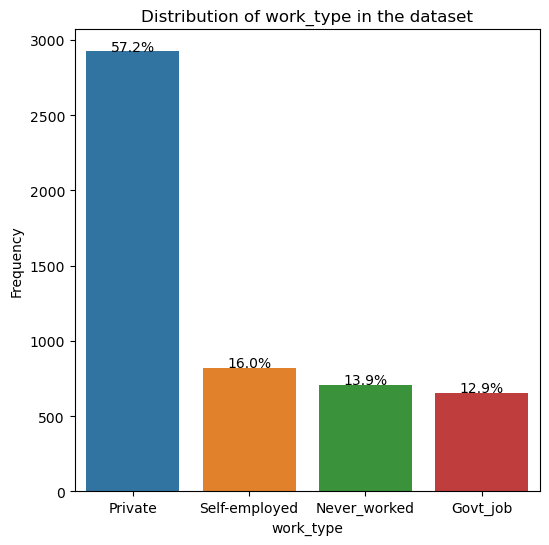

In [16]:
count_df = categories_count(dataset,'work_type')
univariate_barplot(count_df,xlabel='work_type')

**<h4>Smoking Status</h4>**

posx and posy should be finite values
posx and posy should be finite values


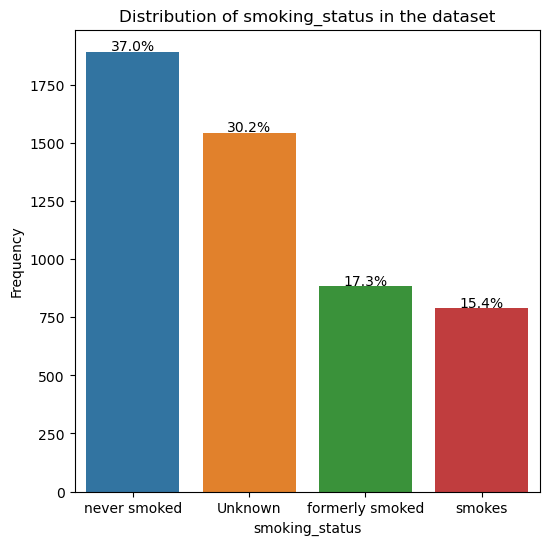

In [17]:
count_df = categories_count(dataset,'smoking_status')
univariate_barplot(count_df,xlabel='smoking_status')

<li><b>37 % of people never smoked, 30.2 % of people's smoking status is unknown.</b></li>

<li><b>Whereas 17.3 % people smoking status is formorly smoken and 15.4 % are regular smokers.</b></li>

<li><b>Since, 30.2 % people's smoking status is unknown, let's explore the age group of those people for drawing more insights.</b></li>


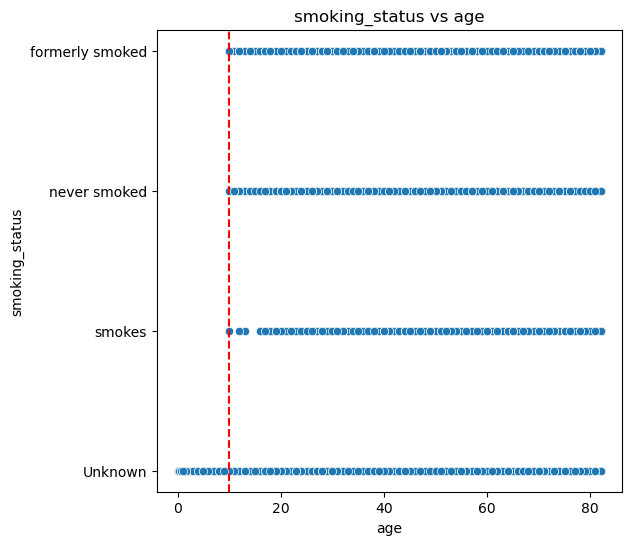

In [18]:
ax=plt.figure(figsize=(6,6))
ax = sns.scatterplot()
ax = sns.scatterplot(x='age',y='smoking_status',data = dataset)
ax.set_title('smoking_status vs age')
ax.set(xlabel='age', ylabel='smoking_status')
plt.axvline(x=10, c='red', linestyle='dashed')
plt.show()



**<h6>Let's make some assumptions on data</h6>**

<li><b>We can clearly see that people below 10 years are not found smoking in this dataset.</b></li>

<li><b>Let's make an assumption that person below 10 years can not smoke</b></li>

<li><b>But there are some people whose smoking status is unknown even if they are below that age limit</b></li>

<li><b>People whose smoking status is unknown and below 10 years age limit will be changed to never smoked</b></li>

<li><b>Then only, we will encode the values to numerical values</b></li>

In [19]:
dataset.loc[(dataset['smoking_status']=="Unknown") & (dataset['age'] < 10),"smoking_status"] = "never smoked" 
dataset.head()

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

**<h4>Hypertension</h4>**

posx and posy should be finite values
posx and posy should be finite values


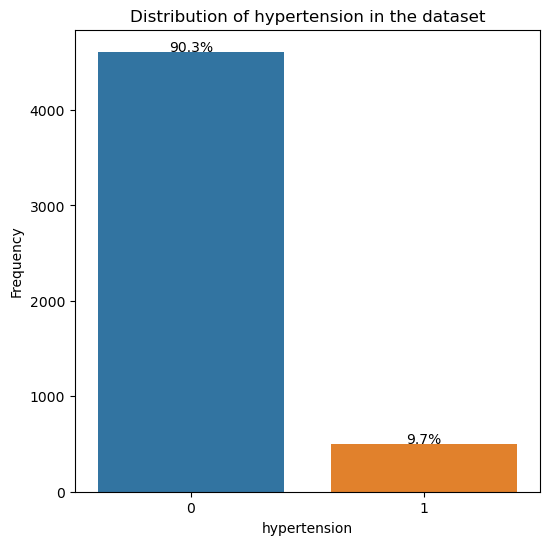

In [20]:
count_df = categories_count(dataset,'hypertension')
univariate_barplot(count_df,xlabel='hypertension')

<li><b>We have 498 patient with hypertension which represents at around 10 % of the sample.</b></li>
<li><b>More than 90% same represent the people with no hypertension in the datasets</b></li>

**<h4>Heart Disease</h4>**

posx and posy should be finite values
posx and posy should be finite values


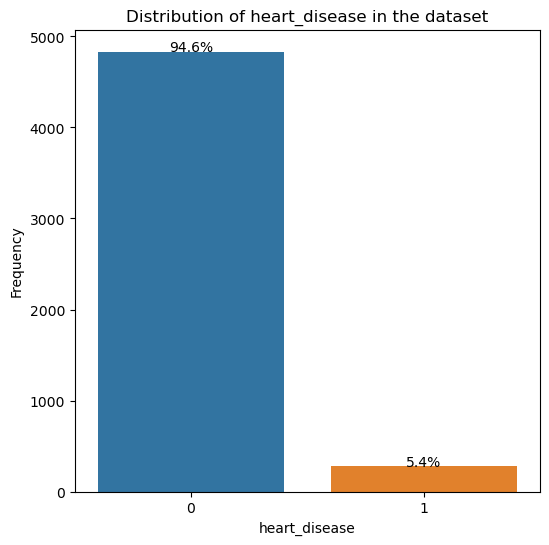

In [21]:
count_df = categories_count(dataset,'heart_disease')
univariate_barplot(count_df,xlabel='heart_disease')

<li><b>We have 276 patient with heart disease which is 5.4 % of the sample.</b></li>
<li><b>More than 94% of samples belong to the people with no heart disease</b></li>

**<h4>Bivariate Analysis</h4>**

In [22]:
def feature_impact_probability(df,features,values):
  with_feature_count = df[df[features[0]]==values[1]][features[1]].value_counts()[1]
  with_feature_total_count = df.loc[df[features[0]]==values[1],features[0]].value_counts().sum()
  without_feature_count = df[df[features[0]]==values[0]][features[1]].value_counts()[1]
  without_feature_total_count = len(df) - with_feature_total_count
  with_feature_probability = round((with_feature_count / with_feature_total_count) * 100, 2)
  without_feature_probability = round((without_feature_count / without_feature_total_count) * 100, 2)
  return with_feature_probability, without_feature_probability

**<h6>Hypertension and Stroke</h6>**

In [23]:
fig = px.histogram(dataset, x="hypertension", color="stroke",width=400, height=400)
fig.show()

In [24]:
with_hypertension_probablity , without_hypertension_probability = feature_impact_probability(dataset,['hypertension','stroke'],[0,1])
print(with_hypertension_probablity)
print(without_hypertension_probability)

13.25
3.97


<li><b>As we have seen, stroke probability for those who has hypertension are quite different than for those who don't.</b></li>

<li><b>People with hypertension are 13.25% likely to get strokes.</b></li>

<li><b>People without hypertension are only 3.97% likely to get strokes.</b></li>

<li><b>It means that person with hypertension are almost 3.3 time more likely to get stroke than the ones who don't have hypertension.</b></li>

**<h4>Gender and Stroke</h4>**

In [25]:
fig = px.histogram(dataset, x="gender", color="stroke",width=400, height=400)
fig.show()

In [26]:
male_probablity , female_probability = feature_impact_probability(dataset,['gender','stroke'],['Female','Male'])
print(male_probablity)
print(female_probability)

5.11
4.71


<li><b>Male compare to female are more likelyto get stroke, but difference between female and male is very small.</b></li>

<li><b>Male population are 5.11% likely to get strokes.</b></li>

<li><b>Female population are 4.71% likely to get strokes.</b></li>

<li><b>It means that person with heart disease are only 1.08 times more likely to get stroke than the ones who don't have hypertension.</b></li>


**<h4>Heart Disease and Stroke</h4>**

In [27]:
fig = px.histogram(dataset, x="heart_disease", color="stroke",width=400, height=400)
fig.show()

In [28]:
with_heart_disease_probability , without_heart_disease_probability = feature_impact_probability(dataset,['heart_disease','stroke'],[0,1])
print(with_heart_disease_probability)
print(without_heart_disease_probability)

17.03
4.18


<li><b>People with heart disease are 17.03% likely to get strokes.</b></li>

<li><b>People without heart disease are only 4.18% likely to get strokes.</b></li>

<li><b>It means that person with heart disease are almost 4.07 times more likely to get stroke than the ones who don't have hypertension.</b></li>

**<h4>Married and Strokes</h4>**

In [29]:
fig = px.histogram(dataset, x="ever_married", color="stroke",width=400, height=400)
fig.show()

In [30]:
with_marriage_probability , without_marriage_probability = feature_impact_probability(dataset,['ever_married','stroke'],['No','Yes'])
print(with_marriage_probability)
print(without_marriage_probability)

6.56
1.65


<li><b>Married people are 6.56% likely to get strokes.</b></li>

<li><b>Unmarried people are only 1.65% likely to get strokes.</b></li>

<li><b>It means that married people are almost 3.98% times more likely to get stroke than the unmarried ones.</b></li>

**<h4>Residence Type and Stroke</h4>**

In [31]:
fig = px.histogram(dataset, x="Residence_type", color="stroke",width=400, height=400)
fig.show()

In [32]:
rural_probability , urban_probability = feature_impact_probability(dataset,['Residence_type','stroke'],['Rural','Urban'])
print(rural_probability)
print(urban_probability)

5.2
4.54


<li><b>People dwelling in rural areas are 5.2% likely to get strokes.</b></li>

<li><b>People dwelling in urban areas are only 1.65% likely to get strokes.</b></li>

<li><b>It means that people dwelling in rural areas are almost 1.15% times more likely to get stroke than the people dwelling in urban areas.</b></li>




**<h4>Work Type and Stroke</h4>**

In [33]:
fig = px.histogram(dataset, x="work_type", color="stroke",width=400, height=400)
fig.show()

In [34]:
print (f'A person with private work type has a probability of {round(dataset[dataset["work_type"]=="Private"]["stroke"].mean()*100,2)} % get a stroke')

print()

print (f'Self-employed person has a probability of {round(dataset[dataset["work_type"]=="Self-employed"]["stroke"].mean()*100,2)} % get a stroke')

print()

print (f'A person with a goverment job has a probability of {round(dataset[dataset["work_type"]=="Govt_job"]["stroke"].mean()*100,2)} % get a stroke')

print()

print (f'A person never worked has a probability of {round(dataset[dataset["work_type"]=="Never_worked"]["stroke"].mean()*100,2)} % get a stroke')

A person with private work type has a probability of 5.1 % get a stroke

Self-employed person has a probability of 7.94 % get a stroke

A person with a goverment job has a probability of 5.02 % get a stroke

A person never worked has a probability of 0.28 % get a stroke


<li><b>Self employed person has more probability to get stroke than other work type.</b></li>

<li><b>This data suggests that if you have never worked, you will not die by stroke !!! Only 0.28% of people who never worked are likely to get stroke.</b></li>

<li><b>Person with private job and goverment job almost has same probability to get stroke.</b></li>



**<h4>Smoking and Stroke</h4>**

In [35]:
fig = px.histogram(dataset, x="smoking_status", color="stroke",width=400, height=400)
fig.show()

In [36]:
print (f'A formerly smoked person has a probability of {round(dataset[dataset["smoking_status"]=="formerly smoked"]["stroke"].mean()*100,2)} % get a stroke')

print()

print (f'A person never smoked has a probability of {round(dataset[dataset["smoking_status"]=="never smoked"]["stroke"].mean()*100,2)} % get a stroke')

print()

print (f'A person smokes has a probability of {round(dataset[dataset["smoking_status"]=="smokes"]["stroke"].mean()*100,2)} % get a stroke')

print()

print (f'A person whom smoking history is not known,has a probability of {round(dataset[dataset["smoking_status"]=="Unknown"]["stroke"].mean()*100,2)} % get a stroke')



A formerly smoked person has a probability of 7.92 % get a stroke

A person never smoked has a probability of 3.85 % get a stroke

A person smokes has a probability of 5.32 % get a stroke

A person whom smoking history is not known,has a probability of 4.28 % get a stroke


<li><b>There are differeneces based on the smoking habits.</b></li>

<li><b>A formerly smoked person has a probability to get stroke 1.66 times more than person never smoked.</b></li>

<li><b>A person smokes has a a probability to get stroke 1.11 times more than person never smoked.</b></li>

<li><b>It is smal difference between who smokes and who does not smoke in regard to probability of getting stroke.</b></li>


**<h4>Numerical Columns</h4>**

**<h6>Univariate Analysis For Numerical Columns</h4>**

In [37]:
categorical = ['gender', 'hypertension', 'heart_disease', 'ever_married',
'work_type', 'Residence_type', 'smoking_status']

numerical = ['age','avg_glucose_level', 'bmi']


**<h4>Bivariate Analysis : Correlation Matrix & Scatter Plots</h4>**

In [38]:
dataset[numerical].corr()

age  avg_glucose_level       bmi
age                1.000000           0.238318  0.333244
avg_glucose_level  0.238318           1.000000  0.175672
bmi                0.333244           0.175672  1.000000

<li><b>There is very small positive correlation between numerical features.</b></li>

<li><b>Let's see the correlation of numerical variables with the target variable</b></li>


In [39]:
dataset[['age','avg_glucose_level','bmi','stroke']].corr()

age  avg_glucose_level       bmi    stroke
age                1.000000           0.238318  0.333244  0.245253
avg_glucose_level  0.238318           1.000000  0.175672  0.131991
bmi                0.333244           0.175672  1.000000  0.042341
stroke             0.245253           0.131991  0.042341  1.000000

<li><b>When age increases, also the mean score on the stroke also increases.</b></li>

<li><b>Average glucose level's mean scores have differences between a person who has a stroke or not.</b?</li>

<li><b>Bmi mean scores are close to each other.</b></li>

<li><b>Correlations with the target variable are very small.</b></li>

<li><b>Among all numerical features, age is the most dominant feature with a correlation of 0.24</b></li>



**<h4><li>Let's finally see the scatter plots</li><h4>**



In [40]:
def scatter_plot(df,features,color_choice):
  fig = px.scatter(df,x=features[0],y=features[1],title="{} and {}".format(features[0],features[1]),
                   color=features[2],color_continuous_scale=color_choice,hover_data=df[[features[2]]])
  fig.show()

**<h6> Age and BMI column</h6>**

In [41]:
scatter_plot(df=dataset,features=['age','bmi','stroke'],color_choice = "magenta")

<li><b>People with age greater than 45 years are likely to get a heart stroke than below age groups.</b></li>

<li><b>Very few people have bmi greater than 60</b></li>


**<h4>Age and Average Glucose Level</h4>**

In [42]:
scatter_plot(df=dataset,features=['age','avg_glucose_level','stroke'],color_choice = "sunset")

<li><b>From this scatterplot, we can see that people with age greater than 45 years are more likely to get a stroke</b></li>

<li><b>People with avg_glucose level higher than 150 mm are more likely to get a stroke than people with lower glucose level than that.</b></li>


**<h4>BMI and Average Glucose Level</h4>**

In [43]:
scatter_plot(df=dataset,features=['bmi','avg_glucose_level','stroke'],color_choice = "temps")

<li><b>Very few people have bmi less than 60 and there is presence of some outliers in bmi value.</b></li>

<li><b>If avg_glucose_level of a person goes higher than 150 mm then, the probability of getting stroke also increases.</li></b>

**<h4>Encoding categorical values for filling the missing values</h4>**

In [44]:
def label_encoder(df,col_name):
  encoder = LabelEncoder()
  df[col_name] = encoder.fit_transform(df[col_name])
  return encoder, df



In [45]:
encoded_dataset = dataset.copy()

gender_encoder, encoded_dataset = label_encoder(encoded_dataset,'gender')


married_encoder, encoded_dataset = label_encoder(encoded_dataset,'ever_married')


residence_encoder, encoded_dataset = label_encoder(encoded_dataset,'Residence_type')



encoded_dataset.drop(['id'],axis='columns',inplace=True)



**<h4>Filling missing values in bmi column</h4>**

In [46]:
from sklearn.impute import KNNImputer
imputter = KNNImputer(n_neighbors=30)
filled_values = imputter.fit_transform(encoded_dataset)


columns = encoded_dataset.columns.tolist()
encoded_dataset = pd.DataFrame(data=filled_values,columns=columns)



<li>291 missing rows of bmi column is imputted using knn imputation method.</li>

<li>We have choose k = 30 as the nearest value to predict our missing values using knn algorithm.</li>

<li>For using imputation techniques, we have encoded our feature variables before train_test split.</li>

<li>The encoding will again be done after splitting the datasets. Here, it is done ahead to fill the missing values only.</li>

<li>We usually do train test split before encoding categorical variables to prevent from data leakage problems.</li>

<li>Filling the missing rows in an original dataset and then performing outlier analysis.</li>

In [47]:
dataset['bmi'] = encoded_dataset['bmi']

**<h4>Outlier Analysis For Numerical Columns</h4>**

**<h6>Age</h6>**

<Axes: >

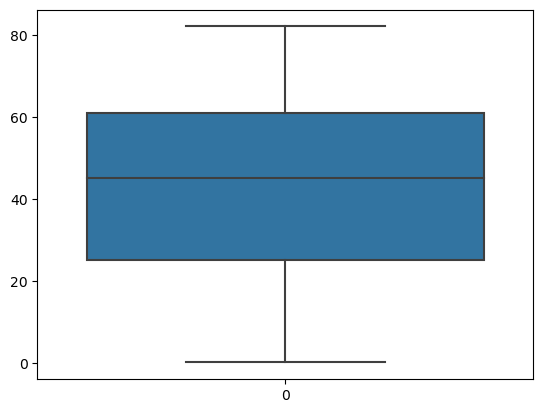

In [48]:
sns.boxplot(dataset['age'])

<li>There is no presence of outlier in Age column.</li>

**<h6>BMI</h6>**

<Axes: >

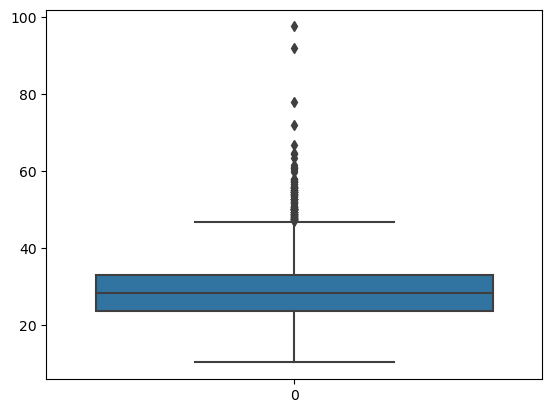

In [49]:
sns.boxplot(dataset['bmi'])

<li>From the given boxplot, we can see that there are many values that is beyond the 3 standard deviation.</li>

<li>Since, the bmi column is not gaussian distributed, so we have to use inter quantile range for detecting the outliers</li>

In [50]:
def iqrrange(df):
  quantile1, quantile3 = np.percentile(df,[25,75])
  iqr_value = quantile3 - quantile1
  lower_bound = quantile1 - 1.5 * iqr_value
  upper_bound = quantile3 + 1.5 * iqr_value
  return lower_bound, upper_bound

In [51]:
lower, higher = iqrrange(dataset['bmi'])
dataset.loc[(dataset['bmi'] < lower) | (dataset['bmi'] > higher),"bmi"] = dataset.loc[(dataset['bmi'] < lower) | (dataset['bmi'] > higher),"bmi"].mean()

<Axes: >

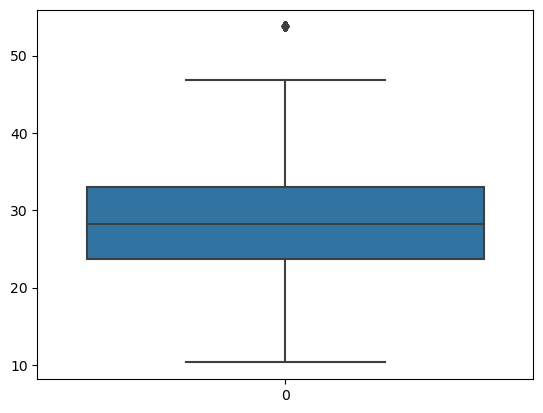

In [52]:
sns.boxplot(dataset['bmi'])

<li>It is not always that outliers are not important for predictive modelling.</li>

<li>In predicting minority class in a class imbalance problem, outliers can play an important role for our model.</li>

<li>Since, we also have class imbalance problem in our dataset, we donot remove the outliers.</li>

<li>Instead of removing it, we have to deal with it smartly.</li>

<li>So I have replace the extreme outlier values with the mean of values that are deviated from the inter quantile range.</li>

**<h4>Average Glucose Level</h4>**

<Axes: >

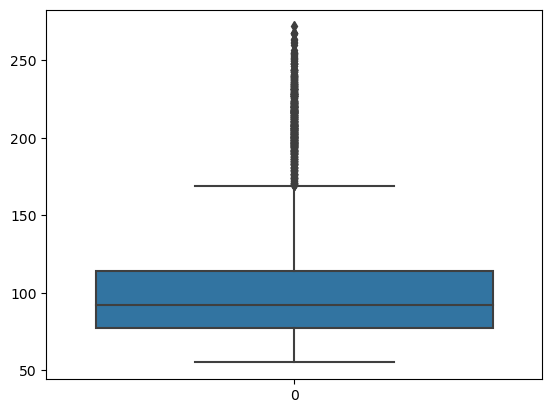

In [53]:
sns.boxplot(dataset['avg_glucose_level'])

<li>From the given boxplot, we can see that there are many values that is beyond the 3 standard deviation.</li>

<li>Since, the avg_glucose_level column is not gaussian distributed, so we have to use inter quantile range for detecting the outliers.</li>

In [54]:
lower, higher = iqrrange(dataset['avg_glucose_level'])
dataset.loc[(dataset['avg_glucose_level'] < lower) | (dataset['avg_glucose_level'] > higher),"avg_glucose_level"] = dataset.loc[(dataset['avg_glucose_level'] < lower) | (dataset['avg_glucose_level'] > higher),"avg_glucose_level"].mean()

<Axes: >

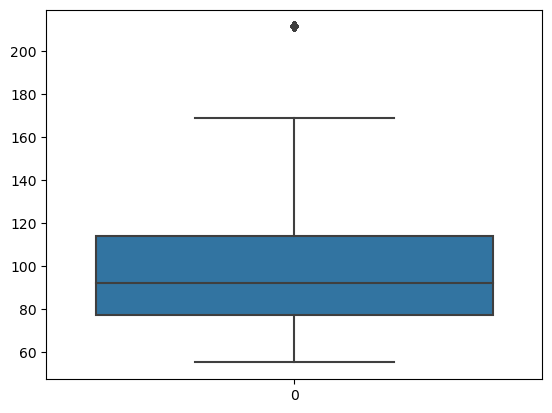

In [55]:
sns.boxplot(dataset['avg_glucose_level'])

<li>The avg_glucose_level values beyond 170 are outliers.</li>

<li>When we recall our findings from multivariate analysis, we have found that the people having avg_glucose_level above 160 are more likely to get stroke.</li>

<li>Since, this outlier can be useful for our problem, we have to keep this outlier values for our predictinve modelling.</li>

<li>Instead of removing it, we have to deal with it smartly.</li>

<li>So I have replace the extreme outlier values with the mean of values that are deviated from the inter quantile range.</li>

**<h4>Insights From Exploratory Data Analysis</h4>**

<li><b>Age and target variable weak positive relationship (almost .25).</b></li>

<li><b>Average glucose level's mean scores on the target have differences between a person who has a stroke or not. But this differences are small.</b></li>

<li><b>BMI does not have any significant relationship with the target variable.</b>

<li><b>A person with hypertension are almost 3.3 time more likely to get stroke than the ones who don't have hypertension.</b></li>

<li><b>Male compare to female are more likely to get stroke, but difference between female and male is very small.</b></li>

<li><b>A person with heart diease are 4.07 times more likely to get stroke than the ones who don't have heart disease.</b></li>

<li><b>A person is married(or married before) are 5.7 times more likely to get stroke than the ones who don't have marriage history.</b></li>

<li><b>Self employed person has more probability to get stroke than other work type.</b></li>

<li><b>Person who lives in rural area slightly has more probablity to get sroke than a person who lives in rural area. Difference is small.</b></li>

<li><b>It is smal difference between who smokes and who does not smoke in regard to probability of getting stroke.</b></li>

**<h2>Target Variable</h2>**

<li>One of the first steps of exploratory data analysis should always be to look at what the values of y look like.</li>

posx and posy should be finite values
posx and posy should be finite values


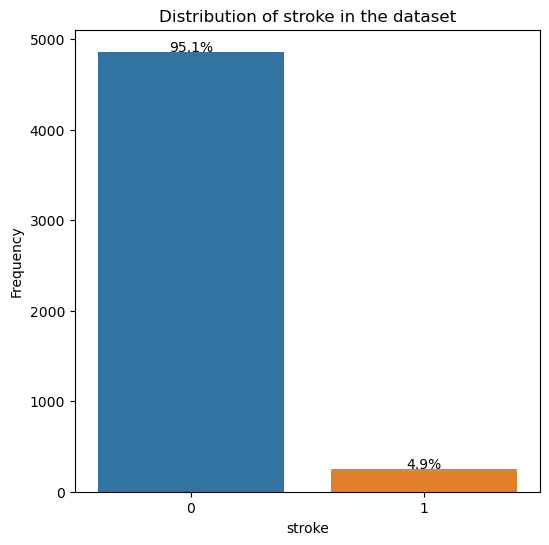

In [56]:
count_df = categories_count(dataset,'stroke')
univariate_barplot(count_df,xlabel='stroke')

<li>Almost %95 of the instances of our target variable is 'No stroke'</li>
<li>4861 patient does not have a stroke.</li>
<li>%5 of the instances of our target variable is 'Stroke'.</li>
<li>249 patient have a stroke.</li>
<li>We have imbalanced data.</li>
<li>Our stroke dataset is an example of a so-called imbalanced dataset.</li>
<li>There are 19 times more people who didn’t have stroke in our data than who had, and we say that the non-stroke class dominates the stroke class.</li>
<li>We can clearly see that: the stroke rate in our data is 0.048
Which is a strong indicator of class imbalance</li>



**<h4>Imbalance Datasets</h4>**

<li>Instances across classes are imbalanced, like in our dataset, we have imbalance data.</li>

<li>The problem is, most of the machine learning algorithm do not work well with the imbalanced data.</li>

<li>Some of the metrics (like accuracy) give us misleading results.</li>

<li>Most of the time in classification problems our interest is to get better predict on the minority class.</li>

<li>In our example: People had a stroke is minority class.</li>

<li>Otherwise our machine learning algorithm falsely predicts majority class.</li>

<li>In our example: No stroke is majority class.</li>

**<h2>Feature Engineering</h2>**

**<h4>Data Preparation and Model Building<h4>**



In [57]:
X = dataset.iloc[:,1:-1]
y = dataset.iloc[:,-1]

In [58]:
x_train, x_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size = 0.2,random_state=42,shuffle=True)
x_train.reset_index(drop=True,inplace=True)
x_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)
X

gender   age  hypertension  heart_disease ever_married      work_type  \
0       Male  67.0             0              1          Yes        Private   
1     Female  61.0             0              0          Yes  Self-employed   
2       Male  80.0             0              1          Yes        Private   
3     Female  49.0             0              0          Yes        Private   
4     Female  79.0             1              0          Yes  Self-employed   
...      ...   ...           ...            ...          ...            ...   
5104  Female  80.0             1              0          Yes        Private   
5105  Female  81.0             0              0          Yes  Self-employed   
5106  Female  35.0             0              0          Yes  Self-employed   
5107    Male  51.0             0              0          Yes        Private   
5108  Female  44.0             0              0          Yes       Govt_job   

     Residence_type  avg_glucose_level        bmi   smoking_status  
0             Urban         211.341595  36.600000  formerly smoked  
1             Rural         211.341595  34.546667     never smoked  
2             Rural         105.920000  32.500000     never smoked  
3             Urban         211.341595  34.400000           smokes  
4             Rural         211.341595  24.000000     never smoked  
...             ...                ...        ...              ...  
5104          Urban          83.750000  26.486667     never smoked  
5105          Urban         125.200000  40.000000     never smoked  
5106          Rural          82.990000  30.600000     never smoked  
5107          Rural         166.290000  25.600000  formerly smoked  
5108          Urban          85.280000  26.200000          Unknown  

[5109 rows x 10 columns]

In [59]:
sex_encoder, x_train = label_encoder(x_train,'gender')
x_test['gender'] = sex_encoder.transform(x_test['gender'])

marital_status_encoder, x_train = label_encoder(x_train,'ever_married')
x_test['ever_married'] = marital_status_encoder.transform(x_test['ever_married'])


residence_location_encoder, x_train = label_encoder(x_train,'Residence_type')
x_test['Residence_type'] = residence_location_encoder.transform(x_test['Residence_type'])



work_encoder, x_train = label_encoder(x_train,'work_type')
x_test['work_type'] = work_encoder.transform(x_test['work_type'])

smoking_encoder, x_train = label_encoder(x_train,'smoking_status')
x_test['smoking_status'] = smoking_encoder.transform(x_test['smoking_status'])

In [60]:
print(x_train.shape)
x_train.head()

(4087, 10)


gender   age  hypertension  heart_disease  ever_married  work_type  \
0       0  48.0             0              0             1          2   
1       0  29.0             0              0             0          2   
2       0  35.0             0              0             1          2   
3       1  38.0             0              0             1          2   
4       1  16.0             0              0             0          0   

   Residence_type  avg_glucose_level   bmi  smoking_status  
0               1              69.21  33.1               2  
1               1              84.19  21.2               2  
2               0             119.40  22.9               2  
3               0             108.68  32.7               2  
4               1              82.34  31.6               0

In [61]:
print("Distribution of y_train = {}".format(y_train.value_counts()))
print("Distribution of y_test = {}".format(y_test.value_counts()))

Distribution of y_train = 0    3888
1     199
Name: stroke, dtype: int64
Distribution of y_test = 0    972
1     50
Name: stroke, dtype: int64


**<h4>Encoding Categorical Variables</h4>**

<li>In gender column, female is encoded to 0 and male is encoded to 1.</li>

<li>In 'ever_married' column, the 'Yes' is converted to 1 and 'No' is converted to 0.</li>

<li>This means married people are encoded to 0 and unmarried people are encoded to 1</li>

<li>In Residence_type column, Rural is encoded to 0 and Urban is encoded to 1.</li>




In [62]:
print(x_train.shape)
x_train.head()

(4087, 10)


gender   age  hypertension  heart_disease  ever_married  work_type  \
0       0  48.0             0              0             1          2   
1       0  29.0             0              0             0          2   
2       0  35.0             0              0             1          2   
3       1  38.0             0              0             1          2   
4       1  16.0             0              0             0          0   

   Residence_type  avg_glucose_level   bmi  smoking_status  
0               1              69.21  33.1               2  
1               1              84.19  21.2               2  
2               0             119.40  22.9               2  
3               0             108.68  32.7               2  
4               1              82.34  31.6               0

In [63]:
x_train

gender   age  hypertension  heart_disease  ever_married  work_type  \
0          0  48.0             0              0             1          2   
1          0  29.0             0              0             0          2   
2          0  35.0             0              0             1          2   
3          1  38.0             0              0             1          2   
4          1  16.0             0              0             0          0   
...      ...   ...           ...            ...           ...        ...   
4082       0  45.0             0              0             1          2   
4083       0  16.0             0              0             0          1   
4084       0  61.0             0              0             1          2   
4085       1  31.0             0              0             1          2   
4086       0  46.0             0              0             1          0   

      Residence_type  avg_glucose_level   bmi  smoking_status  
0                  1              69.21  33.1               2  
1                  1              84.19  21.2               2  
2                  0             119.40  22.9               2  
3                  0             108.68  32.7               2  
4                  1              82.34  31.6               0  
...              ...                ...   ...             ...  
4082               1              92.86  35.1               1  
4083               0             113.47  19.5               0  
4084               0              78.65  36.2               1  
4085               1              74.05  26.0               0  
4086               1              55.84  27.8               2  

[4087 rows x 10 columns]

In [64]:
x_test

gender   age  hypertension  heart_disease  ever_married  work_type  \
0          0  28.0             1              0             1          0   
1          0   3.0             0              0             0          1   
2          0  53.0             0              0             1          0   
3          1  35.0             0              0             1          2   
4          0  58.0             0              0             1          2   
...      ...   ...           ...            ...           ...        ...   
1017       0  24.0             1              0             0          2   
1018       0  48.0             1              0             0          2   
1019       0  37.0             0              0             0          3   
1020       1  18.0             0              0             0          2   
1021       1  46.0             0              0             1          2   

      Residence_type  avg_glucose_level        bmi  smoking_status  
0                  0              83.66  36.400000               2  
1                  1              93.30  19.500000               2  
2                  0              64.40  31.000000               3  
3                  0              69.22  42.800000               2  
4                  0              94.30  29.100000               0  
...              ...                ...        ...             ...  
1017               1             107.22  35.300000               3  
1018               0             118.14  28.036667               1  
1019               1              90.71  45.800000               0  
1020               1              79.35  23.600000               0  
1021               1              58.42  24.700000               1  

[1022 rows x 10 columns]

In [65]:
print(x_test.shape)
x_test
dataset.describe()

(1022, 10)


id          age  hypertension  heart_disease  \
count   5109.000000  5109.000000   5109.000000    5109.000000   
mean   36513.985516    43.232727      0.097475       0.054022   
std    21162.008804    22.609703      0.296633       0.226084   
min       67.000000     0.080000      0.000000       0.000000   
25%    17740.000000    25.000000      0.000000       0.000000   
50%    36922.000000    45.000000      0.000000       0.000000   
75%    54643.000000    61.000000      0.000000       0.000000   
max    72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       stroke  
count        5109.000000  5109.000000  5109.000000  
mean          106.140399    28.945734     0.048738  
std            44.694285     7.660570     0.215340  
min            55.120000    10.300000     0.000000  
25%            77.240000    23.700000     0.000000  
50%            91.880000    28.280000     0.000000  
75%           114.090000    33.000000     0.000000  
max           211.341595    53.774359     1.000000

**<h4>Feature Scaling</h4>**

In [66]:
# fit on training data column
scale = StandardScaler()

x_train = scale.fit_transform(x_train)

x_test = scale.transform(x_test)


In [67]:
#making a scaler object to connect with our GUI
import pickle
import os
root = os.chdir(r'C:\Users\Prason\Desktop\capstone')

scale

StandardScaler()

In [68]:
scaler_path = os.path.join(r'C:\Users\Prason\Desktop\capstone','models/scaler.pkl')
with open(scaler_path,'wb') as scaler_file:
    pickle.dump(scale,scaler_file)

**<h4>Model Preparation</h4>**

**<h6>Decide the metric</h6>**

<li>This is the first step when approaching a machine learning problem: decide the metric!</li>

<li>The choice of the wrong metric can mean choosing the wrong algorithm.</li>

<li>We see that the target is skewed and thus the best metric for this binary classification problem would be <b>Area Under the ROC Curve (AUC).</b></li>

<li>We can use <b>precision and recall</b> too, but AUC combines these two metrics.</li>

<li>We have already seen the label/target distribution, and we know that it is a binary classification problem with skewed targets.</li>

<li>Just for further info, it is not advisable to use accuracy as an evaluation metric, when dealing with higly imbalanced data.</li>

**<h6>Model Selection</h6>**

<li>We will explore multiple models : <b>Logistic Regression, Decision Trees and Random Forests</b></li>

<li>Decide which model perform the best in the evaluated models.</li>

<li><b>Let's start by creating a Logistic Regression Model at first.</b></li>

In [69]:
print(x_train.shape)

(4087, 10)


In [70]:
models = {
    "                   Logistic Regression": LogisticRegression(),
    "                   K-Nearest Neighbors": KNeighborsClassifier(),
    "                         Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine (Linear Kernel)": LinearSVC(),
    "   Support Vector Machine (RBF Kernel)": SVC(),
    "                         Random Forest": RandomForestClassifier(),
    "                     Gradient Boosting": GradientBoostingClassifier(),
    "                               XGBoost": XGBClassifier(eval_metric='mlogloss')
}



In [71]:
for name, model in models.items():
    model.fit(x_train, y_train)
    print(name + " trained.")

                   Logistic Regression trained.
                   K-Nearest Neighbors trained.
                         Decision Tree trained.


C:\Users\Prason\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



Support Vector Machine (Linear Kernel) trained.
   Support Vector Machine (RBF Kernel) trained.
                         Random Forest trained.
                     Gradient Boosting trained.
                               XGBoost trained.


In [72]:
print("Model Performance\n-----------------")
for name, model in models.items():
    y_pred = model.predict(x_test)
    print(
        "\n" + name + " Roc Auc Score: {:.3f}%\n\t\t\t\t       F1-Score: {:.5f}"\
        .format(roc_auc_score(y_test, y_pred) * 100, f1_score(y_test, y_pred))
    )

Model Performance
-----------------

                   Logistic Regression Roc Auc Score: 50.000%
				       F1-Score: 0.00000

                   K-Nearest Neighbors Roc Auc Score: 49.897%
				       F1-Score: 0.00000

                         Decision Tree Roc Auc Score: 51.605%
				       F1-Score: 0.08264

Support Vector Machine (Linear Kernel) Roc Auc Score: 50.000%
				       F1-Score: 0.00000

   Support Vector Machine (RBF Kernel) Roc Auc Score: 50.000%
				       F1-Score: 0.00000

                         Random Forest Roc Auc Score: 49.949%
				       F1-Score: 0.00000

                     Gradient Boosting Roc Auc Score: 52.691%
				       F1-Score: 0.10169

                               XGBoost Roc Auc Score: 55.331%
				       F1-Score: 0.17391


<li>The model has very less roc auc score.</li>

<li>LightGBM and Decision Tree Forest were able to get a F1 score of around 9% which is very low. </li>

<li>The models like Logistic Regression and SVM is not detecting any stroke cases</li>

<li>Since, the target class is only 5% of the whole dataset. So, we are facing this issue.</li>

<li><b>Let's do oversampling of underrepresented class on our training set to handle class imbalance problem</b></li>

In [73]:
x_train


array([[-0.83967135,  0.20933505, -0.32341088, ..., -0.83035902,
         0.54605153,  0.45206932],
       [-0.83967135, -0.63000651, -0.32341088, ..., -0.49196423,
        -1.00880419,  0.45206932],
       [-0.83967135, -0.36495128, -0.32341088, ...,  0.30342166,
        -0.78668195,  0.45206932],
       ...,
       [-0.83967135,  0.78362137, -0.32341088, ..., -0.61711157,
         0.95109797, -0.56365763],
       [ 1.19094215, -0.54165477, -0.32341088, ..., -0.72102452,
        -0.3816355 , -1.57938458],
       [-0.83967135,  0.1209833 , -0.32341088, ..., -1.13238428,
        -0.14644724,  0.45206932]])

In [74]:
from imblearn.over_sampling import SMOTE
smote=SMOTE()
x_train,y_train = smote.fit_resample(x_train,y_train)
print(len(x_train))
print(len(y_train))

7776
7776


In [75]:
smote_path = os.path.join(r'C:\Users\Prason\Desktop\capstone/','models/smote.pkl')
with open(smote_path,'wb') as scaler_file:
    pickle.dump(smote,scaler_file)

In [76]:
for name, model in models.items():
    model.fit(x_train, y_train)
    print(name + " trained.")

                   Logistic Regression trained.
                   K-Nearest Neighbors trained.
                         Decision Tree trained.


C:\Users\Prason\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



Support Vector Machine (Linear Kernel) trained.
   Support Vector Machine (RBF Kernel) trained.
                         Random Forest trained.
                     Gradient Boosting trained.
                               XGBoost trained.


In [77]:
print("Model Performance\n-----------------")
for name, model in models.items():
    y_pred = model.predict(x_test)
    print(
        "\n" + name + " Roc Auc Score: {:.3f}%\n\t\t\t\t       F1-Score: {:.5f}"\
        .format(roc_auc_score(y_test, y_pred) * 100, f1_score(y_test, y_pred))
    )

Model Performance
-----------------

                   Logistic Regression Roc Auc Score: 77.191%
				       F1-Score: 0.23599

                   K-Nearest Neighbors Roc Auc Score: 60.872%
				       F1-Score: 0.16740

                         Decision Tree Roc Auc Score: 59.193%
				       F1-Score: 0.18978

Support Vector Machine (Linear Kernel) Roc Auc Score: 76.728%
				       F1-Score: 0.22989

   Support Vector Machine (RBF Kernel) Roc Auc Score: 69.043%
				       F1-Score: 0.20478

                         Random Forest Roc Auc Score: 56.405%
				       F1-Score: 0.17978

                     Gradient Boosting Roc Auc Score: 68.393%
				       F1-Score: 0.26230

                               XGBoost Roc Auc Score: 56.611%
				       F1-Score: 0.18824


<li>After oversampling, we can see that Logistic Regression and Linear SVM outperforms other models.</li>

<li>We get roc auc score of 77.72% and a F1 score of around 0.23 from Logistic regression model</li>

<li>Linear SVM has an roc auc score of 78.163 and  F1 score of around 0.23</li>

<li>We can use any model as our final model and perform some hypertuning optimization to see if performance improves.</li>

Text(0.5, 1.0, 'Correlation Heatmap')

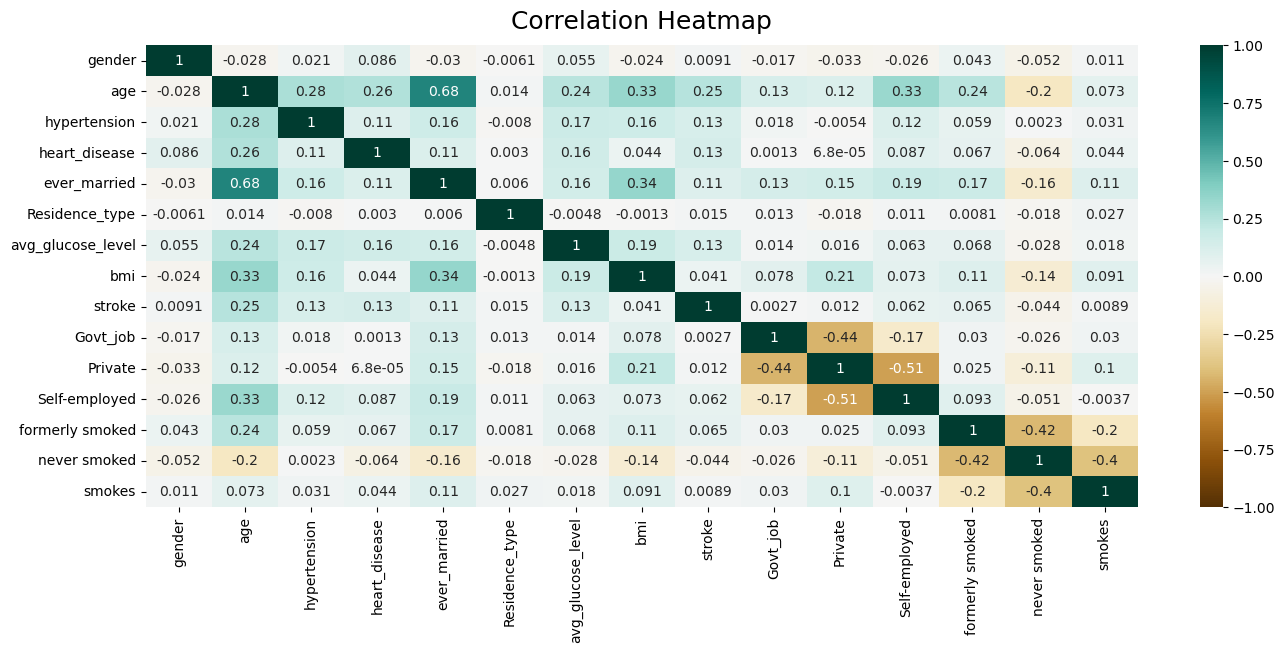

In [78]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(encoded_dataset.corr(), vmin=-1, vmax=1, annot=True,cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

<li><b>Assumption: There is no extreme outliers</b></li>
<li>We have deal with the outliers properly in avg_glucose_level column and bmi column.</li>
<li>We have use IQR(Inter quantile range) to detect extreme outliers and replace them with the mean of the outliers values</li>
<li>We can not remove the outliers because outliers play a vital role in predicting the target variables</li>


In [79]:
clf = LogisticRegression()
clf.fit(x_train,y_train)

LogisticRegression()

In [80]:
#Predict the response for test dataset
y_pred = clf.predict(x_test)

print("Roc Auc Score : ",roc_auc_score(y_test, y_pred))

Roc Auc Score :  0.7719135802469136


In [81]:
confusion_matrix(y_test,y_pred)

array([[723, 249],
       [ 10,  40]], dtype=int64)

In [82]:
import joblib

In [83]:
lr=LogisticRegression()
lr.fit(x_train,y_train)
y_pred_lr=lr.predict(x_test)
acc_lr=roc_auc_score(y_test,y_pred_lr)

In [84]:
model_path=os.path.join(r'C:\Users\Prason\Desktop\capstone/','models/ntlrmodel.sav')
joblib.dump(lr,model_path)

['C:\\Users\\Prason\\Desktop\\capstone/models/ntlrmodel.sav']

In [85]:
knn=KNeighborsClassifier()
knn.fit(x_train,y_train)
y_pred_knn = knn.predict(x_test)
acc_knn = roc_auc_score(y_test, y_pred_knn)

In [86]:
model_path_knn=os.path.join('C:/Users/Prason/Desktop/capstone/','models/knnmodel.sav')
joblib.dump(knn,model_path_knn)

['C:/Users/Prason/Desktop/capstone/models/knnmodel.sav']

In [87]:
dect=DecisionTreeClassifier()
dect.fit(x_train,y_train)
y_pred_dect = dect.predict(x_test)
acc_dect = roc_auc_score(y_test, y_pred_dect)


In [88]:
model_path_dect=os.path.join('C:/Users/Prason/Desktop/capstone/','models/dectmodel.sav')
joblib.dump(dect,model_path_dect)

['C:/Users/Prason/Desktop/capstone/models/dectmodel.sav']

In [89]:
lsvc=LinearSVC()
lsvc.fit(x_train,y_train)
y_pred_lsvc = lsvc.predict(x_test)
acc_lsvc = roc_auc_score(y_test, y_pred_lsvc)

In [90]:
model_path_lsvc=os.path.join('C:/Users/Prason/Desktop/capstone/','models/lsvcmodel.sav')
joblib.dump(lsvc,model_path_lsvc)

['C:/Users/Prason/Desktop/capstone/models/lsvcmodel.sav']

In [91]:
svc=SVC()
svc.fit(x_train,y_train)
y_pred_svc = svc.predict(x_test)
acc_svc = roc_auc_score(y_test, y_pred_svc)

In [92]:
model_path_svc=os.path.join('C:/Users/Prason/Desktop/capstone/','models/svcmodel.sav')
joblib.dump(svc,model_path_svc)

['C:/Users/Prason/Desktop/capstone/models/svcmodel.sav']

In [93]:
rfc=RandomForestClassifier()
rfc.fit(x_train,y_train)
y_pred_rfc = rfc.predict(x_test)
acc_rfc = roc_auc_score(y_test, y_pred_rfc)

In [94]:
model_path_rfc=os.path.join('C:/Users/Prason/Desktop/capstone/','models/rfcmodel.sav')
joblib.dump(rfc,model_path_rfc)

['C:/Users/Prason/Desktop/capstone/models/rfcmodel.sav']

In [95]:
gbc=GradientBoostingClassifier()
gbc.fit(x_train,y_train)
y_pred_gbc = gbc.predict(x_test)
acc_gbc = roc_auc_score(y_test, y_pred_gbc)

In [96]:
model_path_gbc=os.path.join('C:/Users/Prason/Desktop/capstone/','models/gbcmodel.sav')
joblib.dump(gbc,model_path_gbc)

['C:/Users/Prason/Desktop/capstone/models/gbcmodel.sav']

In [97]:
xgbc=XGBClassifier(eval_metric='mlogloss')
xgbc.fit(x_train,y_train)
y_pred_xgbc = xgbc.predict(x_test)
acc_xgbc = roc_auc_score(y_test, y_pred_xgbc)

In [98]:
model_path_xgbc=os.path.join('C:/Users/Prason/Desktop/capstone/','models/xgbcmodel.sav')
joblib.dump(xgbc,model_path_xgbc)

['C:/Users/Prason/Desktop/capstone/models/xgbcmodel.sav']

**<h4>Conclusion</h4>**


<li><b>On our first hypothesis, we have thought bmi would be a good indicator or measure in predicting the likelihood of getting a stroke.</b?</li>

<li><b>But, according to the data, there are many outliers in the bmi column and found as a weak feature for our target which is against the medical use case.</b></li>

<li><b>Accuracy metric is not a good metric to choose for imbalance datasets.</b></li>

<li><b>F1 score and Roc-Auc score is a reliable metric for class imbalance problem like ours</b></li>

<li><b>Oversampling techniques like Smote are really good tools to use incase of class imbalance problems.</b></li>

<li><b>Logistic Regression model and SVM model are the top performing models with ROC-AUC score of around 77% and a F1 score of around 0.23.</b></li>

<li><b>More features can be added to the dataset such as the patient's exercise pattern, blood pressure and so on.</b></li>


<li><b>Since it has high recall and low precision, early signs or predictions of  getting a stroke can be useful for the patient to take care of their health problems even more seriously.</b></li>
    
<li><b>Neural networks can be used for this problem which can boost the performance and give us reliable result which will be beneficial for early diagnosis of heartstroke and further various neural networks can be explored.</b></li>


**<h4> BUILDING OUR OWN NEURAL NETWORK MODEL</h4>**

In [99]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [100]:
cmodel = Sequential()
cmodel.add(Dense(64, input_dim = len(x_train[0,:]),activation='relu'))
cmodel.add(Dense(16, activation='relu'))
cmodel.add(Dense(8, activation='relu'))
cmodel.add(Dense(4, activation='relu'))
cmodel.add(Dense(1, activation='sigmoid'))
print(cmodel.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                704       
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 dense_4 (Dense)             (None, 1)                 5         
                                                                 
Total params: 1921 (7.50 KB)
Trainable params: 1921 (7.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [101]:
#compile method


cmodel.compile(loss='binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics=['accuracy'])

In [102]:
#train our model

from keras.callbacks import EarlyStopping, ModelCheckpoint
callbacka = ModelCheckpoint(filepath = 'best_model.hdf5', monitor = 'val_loss', save_best_only=True, save_weights_only=True)
callbackb = EarlyStopping(monitor = 'val_loss', mode='min', patience=10, verbose=1)

In [103]:
#finally fiiting our model

In [104]:
chistory=cmodel.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=256, batch_size = 16, callbacks=[callbacka])

Epoch 1/256
486/486 [==============================] - 2s 2ms/step - loss: 0.6807 - accuracy: 0.5484 - val_loss: 0.7917 - val_accuracy: 0.2750
Epoch 2/256
486/486 [==============================] - 1s 2ms/step - loss: 0.6303 - accuracy: 0.6791 - val_loss: 0.8008 - val_accuracy: 0.5039
Epoch 3/256
486/486 [==============================] - 1s 2ms/step - loss: 0.6032 - accuracy: 0.7523 - val_loss: 0.8080 - val_accuracy: 0.5705
Epoch 4/256
486/486 [==============================] - 1s 2ms/step - loss: 0.5614 - accuracy: 0.7834 - val_loss: 0.6885 - val_accuracy: 0.7035
Epoch 5/256
486/486 [==============================] - 1s 2ms/step - loss: 0.5189 - accuracy: 0.7937 - val_loss: 0.6266 - val_accuracy: 0.7319
Epoch 6/256
486/486 [==============================] - 1s 2ms/step - loss: 0.4796 - accuracy: 0.8013 - val_loss: 0.5545 - val_accuracy: 0.7505
Epoch 7/256
486/486 [==============================] - 1s 2ms/step - loss: 0.4503 - accuracy: 0.8089 - val_loss: 0.5281 - val_accuracy: 0.7515

Epoch 58/256
486/486 [==============================] - 1s 2ms/step - loss: 0.2644 - accuracy: 0.8984 - val_loss: 0.3974 - val_accuracy: 0.8151
Epoch 59/256
486/486 [==============================] - 1s 2ms/step - loss: 0.2624 - accuracy: 0.9003 - val_loss: 0.4193 - val_accuracy: 0.8023
Epoch 60/256
486/486 [==============================] - 1s 2ms/step - loss: 0.2600 - accuracy: 0.9011 - val_loss: 0.4273 - val_accuracy: 0.7994
Epoch 61/256
486/486 [==============================] - 1s 2ms/step - loss: 0.2582 - accuracy: 0.9033 - val_loss: 0.3901 - val_accuracy: 0.8229
Epoch 62/256
486/486 [==============================] - 1s 2ms/step - loss: 0.2558 - accuracy: 0.9032 - val_loss: 0.4054 - val_accuracy: 0.8131
Epoch 63/256
486/486 [==============================] - 1s 2ms/step - loss: 0.2538 - accuracy: 0.9034 - val_loss: 0.3981 - val_accuracy: 0.8180
Epoch 64/256
486/486 [==============================] - 1s 2ms/step - loss: 0.2515 - accuracy: 0.9051 - val_loss: 0.3995 - val_accuracy:

Epoch 115/256
486/486 [==============================] - 1s 2ms/step - loss: 0.1685 - accuracy: 0.9461 - val_loss: 0.4176 - val_accuracy: 0.8571
Epoch 116/256
486/486 [==============================] - 1s 2ms/step - loss: 0.1679 - accuracy: 0.9446 - val_loss: 0.4265 - val_accuracy: 0.8503
Epoch 117/256
486/486 [==============================] - 1s 2ms/step - loss: 0.1664 - accuracy: 0.9461 - val_loss: 0.4344 - val_accuracy: 0.8513
Epoch 118/256
486/486 [==============================] - 1s 2ms/step - loss: 0.1653 - accuracy: 0.9491 - val_loss: 0.4100 - val_accuracy: 0.8679
Epoch 119/256
486/486 [==============================] - 1s 2ms/step - loss: 0.1646 - accuracy: 0.9488 - val_loss: 0.4159 - val_accuracy: 0.8591
Epoch 120/256
486/486 [==============================] - 1s 2ms/step - loss: 0.1630 - accuracy: 0.9483 - val_loss: 0.4299 - val_accuracy: 0.8611
Epoch 121/256
486/486 [==============================] - 1s 2ms/step - loss: 0.1620 - accuracy: 0.9480 - val_loss: 0.4136 - val_ac

486/486 [==============================] - 1s 2ms/step - loss: 0.1052 - accuracy: 0.9672 - val_loss: 0.5827 - val_accuracy: 0.8826
Epoch 228/256
486/486 [==============================] - 1s 2ms/step - loss: 0.1048 - accuracy: 0.9686 - val_loss: 0.6008 - val_accuracy: 0.8757
Epoch 229/256
486/486 [==============================] - 1s 2ms/step - loss: 0.1044 - accuracy: 0.9690 - val_loss: 0.6043 - val_accuracy: 0.8718
Epoch 230/256
486/486 [==============================] - 1s 2ms/step - loss: 0.1033 - accuracy: 0.9690 - val_loss: 0.5854 - val_accuracy: 0.8865
Epoch 231/256
486/486 [==============================] - 1s 2ms/step - loss: 0.1030 - accuracy: 0.9680 - val_loss: 0.5805 - val_accuracy: 0.8894
Epoch 232/256
486/486 [==============================] - 1s 2ms/step - loss: 0.1026 - accuracy: 0.9686 - val_loss: 0.5963 - val_accuracy: 0.8845
Epoch 233/256
486/486 [==============================] - 1s 2ms/step - loss: 0.1031 - accuracy: 0.9680 - val_loss: 0.5908 - val_accuracy: 0.8836

In [105]:
model_path_cnna=os.path.join(r'C:\Users\Prason\Desktop\capstone','models/cnnamodel.sav')
joblib.dump(cmodel,model_path_cnna)

['C:\\Users\\Prason\\Desktop\\capstone\\models/cnnamodel.sav']

In [106]:
print('Summary of the results after each epochs ')
hist = pd.DataFrame(chistory.history)
hist['epoch'] = chistory.epoch
hist.tail()

Summary of the results after each epochs 


loss  accuracy  val_loss  val_accuracy  epoch
251  0.096437  0.970936  0.624966      0.884540    251
252  0.095907  0.970936  0.626154      0.890411    252
253  0.096528  0.971836  0.630730      0.884540    253
254  0.095667  0.972608  0.647947      0.874755    254
255  0.095593  0.972222  0.623827      0.898239    255

{'verbose': 1, 'epochs': 256, 'steps': 486}


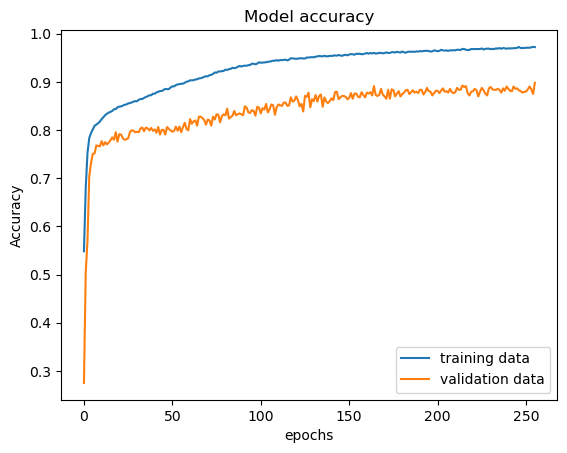

In [107]:
#some visulatization on the resuts we are obtaining for accuracy
print(chistory.params)
plt.plot(chistory.history['accuracy'])
plt.plot(chistory.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(['training data','validation data'], loc = 'lower right')
plt.title('Model accuracy')
plt.show()

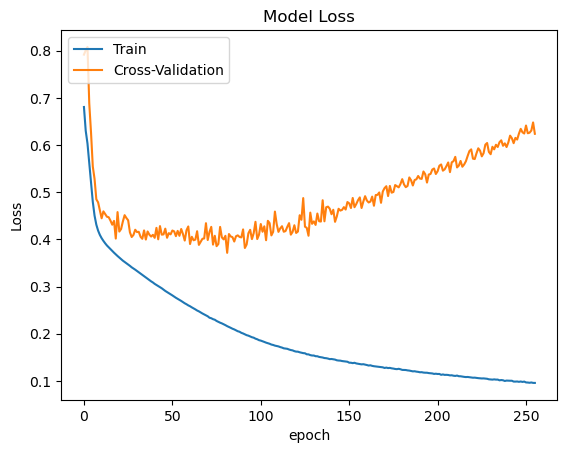

In [108]:
plt.plot(chistory.history['loss'])
plt.plot(chistory.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Cross-Validation'], loc='upper left')
plt.show()

In [109]:
cmodel.load_weights('best_model.hdf5')

In [110]:
scores = cmodel.evaluate(x_train, y_train)
print(cmodel.metrics_names)
print(scores)
print("\n%s %.2f%%" % (cmodel.metrics_names[1], scores[1]*100))

243/243 [==============================] - 0s 2ms/step - loss: 0.2155 - accuracy: 0.9258
['loss', 'accuracy']
[0.215501070022583, 0.9257973432540894]

accuracy 92.58%


In [111]:
#test data accuracy 
scores = cmodel.evaluate(x_test, y_test)
print("\n%s %.2f%%" % (cmodel.metrics_names[1], scores[1]*100))

32/32 [==============================] - 0s 2ms/step - loss: 0.3714 - accuracy: 0.8444

accuracy 84.44%


In [112]:
cmpred = cmodel.predict(x_test)

32/32 [==============================] - 0s 1ms/step


In [113]:
cmpred.shape

(1022, 1)

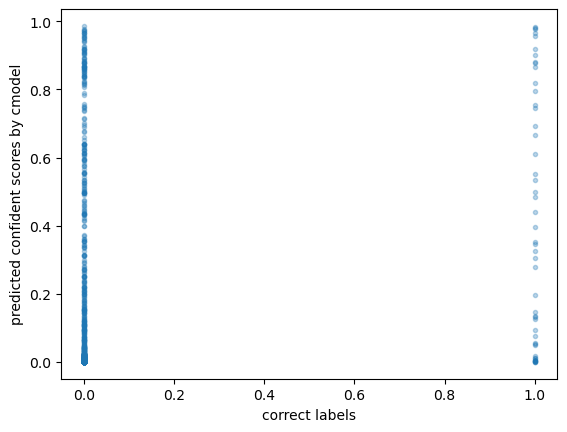

In [114]:
plt.plot(y_test, cmpred, '.', alpha = 0.3)
plt.xlabel('correct labels')
plt.ylabel('predicted confident scores by cmodel')
plt.show()

In [115]:
cm_acc = accuracy_score(y_test.round(), cmpred.round())

print("Accuracy of our model is %.2f%%" % (cm_acc * 100))



Accuracy of our model is 84.44%


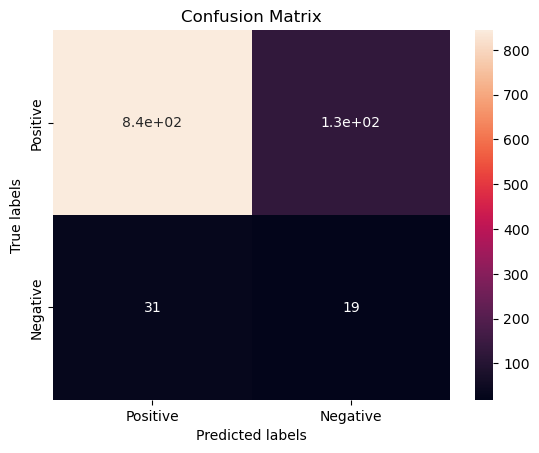

In [116]:
ax= plt.subplot()
predict_results = cmpred

predict_results = (predict_results > 0.5)

cm = confusion_matrix(y_test, predict_results)

sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Positive', 'Negative']); ax.yaxis.set_ticklabels(['Positive', 'Negative']);

<b> Convolution Neural network model <b>

In [117]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
callbackas = ModelCheckpoint(filepath = 'best_model_cnn.hdf5', monitor = 'val_loss', save_best_only=True, save_weights_only=True)
callbackbs = EarlyStopping(monitor = 'val_loss', mode='min', verbose=1)

In [118]:
import os
def create_model_checkpoint(model_name, save_path = "cnnb"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose = 0,
                                            save_best_only = True)

In [119]:
import tensorflow as tf
from tensorflow.keras import layers
tf.random.set_seed(42)

model_1D = tf.keras.Sequential([
    layers.Lambda(lambda x_train: tf.expand_dims(x_train, axis = 1)),
    layers.Conv1D(filters = 128, kernel_size = 7, strides = 1, padding = "causal", activation = "relu" ),
    layers.Dense(8, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(1, activation='sigmoid')
],  name = "model_1D")


model_1D.compile(loss='binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics=['accuracy'])

cmodelh=model_1D.fit(x_train,y_train,
            batch_size = 128,
            epochs = 256,
            verbose = 1,
            validation_data = (x_test, y_test),
            callbacks=[create_model_checkpoint(model_name = "modeldd")])

Epoch 1/256
42/61 [===================>..........] - ETA: 0s - loss: 0.6911 - accuracy: 0.5701INFO:tensorflow:Assets written to: cnnb\modeldd\assets


INFO:tensorflow:Assets written to: cnnb\modeldd\assets


61/61 [==============================] - 3s 27ms/step - loss: 0.6875 - accuracy: 0.6066 - val_loss: 0.6659 - val_accuracy: 0.6986
Epoch 2/256
53/61 [=========================>....] - ETA: 0s - loss: 0.6588 - accuracy: 0.7280INFO:tensorflow:Assets written to: cnnb\modeldd\assets


INFO:tensorflow:Assets written to: cnnb\modeldd\assets


61/61 [==============================] - 1s 23ms/step - loss: 0.6562 - accuracy: 0.7294 - val_loss: 0.6049 - val_accuracy: 0.7642
Epoch 3/256
45/61 [=====================>........] - ETA: 0s - loss: 0.6220 - accuracy: 0.7554INFO:tensorflow:Assets written to: cnnb\modeldd\assets


INFO:tensorflow:Assets written to: cnnb\modeldd\assets


61/61 [==============================] - 1s 22ms/step - loss: 0.6168 - accuracy: 0.7612 - val_loss: 0.5435 - val_accuracy: 0.7642
Epoch 4/256
53/61 [=========================>....] - ETA: 0s - loss: 0.5820 - accuracy: 0.7759INFO:tensorflow:Assets written to: cnnb\modeldd\assets


INFO:tensorflow:Assets written to: cnnb\modeldd\assets


61/61 [==============================] - 1s 17ms/step - loss: 0.5807 - accuracy: 0.7742 - val_loss: 0.5029 - val_accuracy: 0.7593
Epoch 5/256
57/61 [===========================>..] - ETA: 0s - loss: 0.5530 - accuracy: 0.7815INFO:tensorflow:Assets written to: cnnb\modeldd\assets


INFO:tensorflow:Assets written to: cnnb\modeldd\assets


61/61 [==============================] - 2s 34ms/step - loss: 0.5512 - accuracy: 0.7825 - val_loss: 0.4734 - val_accuracy: 0.7564
Epoch 6/256
51/61 [========================>.....] - ETA: 0s - loss: 0.5279 - accuracy: 0.7929INFO:tensorflow:Assets written to: cnnb\modeldd\assets


INFO:tensorflow:Assets written to: cnnb\modeldd\assets


61/61 [==============================] - 2s 41ms/step - loss: 0.5267 - accuracy: 0.7904 - val_loss: 0.4546 - val_accuracy: 0.7505
Epoch 7/256
57/61 [===========================>..] - ETA: 0s - loss: 0.5058 - accuracy: 0.7967INFO:tensorflow:Assets written to: cnnb\modeldd\assets


INFO:tensorflow:Assets written to: cnnb\modeldd\assets


61/61 [==============================] - 2s 30ms/step - loss: 0.5060 - accuracy: 0.7969 - val_loss: 0.4434 - val_accuracy: 0.7436
Epoch 8/256
43/61 [====================>.........] - ETA: 0s - loss: 0.4855 - accuracy: 0.8063INFO:tensorflow:Assets written to: cnnb\modeldd\assets


INFO:tensorflow:Assets written to: cnnb\modeldd\assets


61/61 [==============================] - 1s 22ms/step - loss: 0.4887 - accuracy: 0.7989 - val_loss: 0.4408 - val_accuracy: 0.7358
Epoch 9/256
56/61 [==========================>...] - ETA: 0s - loss: 0.4760 - accuracy: 0.8006INFO:tensorflow:Assets written to: cnnb\modeldd\assets


INFO:tensorflow:Assets written to: cnnb\modeldd\assets


61/61 [==============================] - 1s 20ms/step - loss: 0.4740 - accuracy: 0.8022 - val_loss: 0.4354 - val_accuracy: 0.7378
Epoch 10/256
58/61 [===========================>..] - ETA: 0s - loss: 0.4619 - accuracy: 0.8052INFO:tensorflow:Assets written to: cnnb\modeldd\assets


INFO:tensorflow:Assets written to: cnnb\modeldd\assets


61/61 [==============================] - 1s 17ms/step - loss: 0.4618 - accuracy: 0.8053 - val_loss: 0.4342 - val_accuracy: 0.7358
Epoch 11/256
56/61 [==========================>...] - ETA: 0s - loss: 0.4503 - accuracy: 0.8075INFO:tensorflow:Assets written to: cnnb\modeldd\assets


INFO:tensorflow:Assets written to: cnnb\modeldd\assets


61/61 [==============================] - 1s 18ms/step - loss: 0.4517 - accuracy: 0.8074 - val_loss: 0.4306 - val_accuracy: 0.7446
Epoch 12/256
61/61 [==============================] - 0s 5ms/step - loss: 0.4432 - accuracy: 0.8099 - val_loss: 0.4369 - val_accuracy: 0.7407
Epoch 13/256
61/61 [==============================] - 0s 3ms/step - loss: 0.4363 - accuracy: 0.8121 - val_loss: 0.4367 - val_accuracy: 0.7427
Epoch 14/256
61/61 [==============================] - 0s 3ms/step - loss: 0.4305 - accuracy: 0.8131 - val_loss: 0.4408 - val_accuracy: 0.7436
Epoch 15/256
61/61 [==============================] - 0s 3ms/step - loss: 0.4258 - accuracy: 0.8156 - val_loss: 0.4404 - val_accuracy: 0.7417
Epoch 16/256
61/61 [==============================] - 0s 4ms/step - loss: 0.4217 - accuracy: 0.8152 - val_loss: 0.4455 - val_accuracy: 0.7387
Epoch 17/256
61/61 [==============================] - 0s 3ms/step - loss: 0.4182 - accuracy: 0.8153 - val_loss: 0.4471 - val_accuracy: 0.7368
Epoch 18/256
61/61

INFO:tensorflow:Assets written to: cnnb\modeldd\assets


61/61 [==============================] - 1s 18ms/step - loss: 0.3741 - accuracy: 0.8396 - val_loss: 0.4300 - val_accuracy: 0.7642
Epoch 40/256
61/61 [==============================] - 0s 4ms/step - loss: 0.3728 - accuracy: 0.8394 - val_loss: 0.4396 - val_accuracy: 0.7603
Epoch 41/256
59/61 [============================>.] - ETA: 0s - loss: 0.3734 - accuracy: 0.8392INFO:tensorflow:Assets written to: cnnb\modeldd\assets


INFO:tensorflow:Assets written to: cnnb\modeldd\assets


61/61 [==============================] - 1s 17ms/step - loss: 0.3712 - accuracy: 0.8404 - val_loss: 0.4256 - val_accuracy: 0.7691
Epoch 42/256
61/61 [==============================] - 0s 3ms/step - loss: 0.3699 - accuracy: 0.8413 - val_loss: 0.4431 - val_accuracy: 0.7593
Epoch 43/256
61/61 [==============================] - 0s 3ms/step - loss: 0.3684 - accuracy: 0.8430 - val_loss: 0.4344 - val_accuracy: 0.7642
Epoch 44/256
61/61 [==============================] - 0s 3ms/step - loss: 0.3671 - accuracy: 0.8436 - val_loss: 0.4398 - val_accuracy: 0.7603
Epoch 45/256
61/61 [==============================] - 0s 3ms/step - loss: 0.3656 - accuracy: 0.8423 - val_loss: 0.4324 - val_accuracy: 0.7652
Epoch 46/256
61/61 [==============================] - 0s 3ms/step - loss: 0.3646 - accuracy: 0.8436 - val_loss: 0.4395 - val_accuracy: 0.7593
Epoch 47/256
61/61 [==============================] - 0s 3ms/step - loss: 0.3634 - accuracy: 0.8448 - val_loss: 0.4276 - val_accuracy: 0.7691
Epoch 48/256
61/61

INFO:tensorflow:Assets written to: cnnb\modeldd\assets


61/61 [==============================] - 1s 16ms/step - loss: 0.3511 - accuracy: 0.8501 - val_loss: 0.4222 - val_accuracy: 0.7691
Epoch 58/256
50/61 [=======================>......] - ETA: 0s - loss: 0.3482 - accuracy: 0.8508INFO:tensorflow:Assets written to: cnnb\modeldd\assets


INFO:tensorflow:Assets written to: cnnb\modeldd\assets


61/61 [==============================] - 1s 17ms/step - loss: 0.3499 - accuracy: 0.8499 - val_loss: 0.4210 - val_accuracy: 0.7671
Epoch 59/256
61/61 [==============================] - 0s 3ms/step - loss: 0.3491 - accuracy: 0.8508 - val_loss: 0.4247 - val_accuracy: 0.7642
Epoch 60/256
61/61 [==============================] - 0s 3ms/step - loss: 0.3480 - accuracy: 0.8511 - val_loss: 0.4308 - val_accuracy: 0.7642
Epoch 61/256
61/61 [==============================] - 0s 3ms/step - loss: 0.3467 - accuracy: 0.8521 - val_loss: 0.4337 - val_accuracy: 0.7642
Epoch 62/256
61/61 [==============================] - 0s 3ms/step - loss: 0.3459 - accuracy: 0.8529 - val_loss: 0.4304 - val_accuracy: 0.7652
Epoch 63/256
49/61 [=======================>......] - ETA: 0s - loss: 0.3445 - accuracy: 0.8520INFO:tensorflow:Assets written to: cnnb\modeldd\assets


INFO:tensorflow:Assets written to: cnnb\modeldd\assets


61/61 [==============================] - 1s 16ms/step - loss: 0.3446 - accuracy: 0.8519 - val_loss: 0.4194 - val_accuracy: 0.7720
Epoch 64/256
61/61 [==============================] - 0s 3ms/step - loss: 0.3439 - accuracy: 0.8533 - val_loss: 0.4310 - val_accuracy: 0.7661
Epoch 65/256
61/61 [==============================] - 0s 3ms/step - loss: 0.3427 - accuracy: 0.8534 - val_loss: 0.4297 - val_accuracy: 0.7681
Epoch 66/256
50/61 [=======================>......] - ETA: 0s - loss: 0.3442 - accuracy: 0.8520INFO:tensorflow:Assets written to: cnnb\modeldd\assets


INFO:tensorflow:Assets written to: cnnb\modeldd\assets


61/61 [==============================] - 1s 22ms/step - loss: 0.3418 - accuracy: 0.8542 - val_loss: 0.4171 - val_accuracy: 0.7750
Epoch 67/256
61/61 [==============================] - 0s 3ms/step - loss: 0.3408 - accuracy: 0.8549 - val_loss: 0.4250 - val_accuracy: 0.7691
Epoch 68/256
61/61 [==============================] - 0s 5ms/step - loss: 0.3398 - accuracy: 0.8551 - val_loss: 0.4292 - val_accuracy: 0.7671
Epoch 69/256
61/61 [==============================] - 0s 4ms/step - loss: 0.3389 - accuracy: 0.8564 - val_loss: 0.4212 - val_accuracy: 0.7730
Epoch 70/256
61/61 [==============================] - 0s 3ms/step - loss: 0.3380 - accuracy: 0.8576 - val_loss: 0.4212 - val_accuracy: 0.7730
Epoch 71/256
61/61 [==============================] - 0s 3ms/step - loss: 0.3372 - accuracy: 0.8560 - val_loss: 0.4286 - val_accuracy: 0.7661
Epoch 72/256
61/61 [==============================] - 0s 3ms/step - loss: 0.3361 - accuracy: 0.8587 - val_loss: 0.4251 - val_accuracy: 0.7720
Epoch 73/256
61/61

INFO:tensorflow:Assets written to: cnnb\modeldd\assets


61/61 [==============================] - 1s 15ms/step - loss: 0.3312 - accuracy: 0.8615 - val_loss: 0.4079 - val_accuracy: 0.7798
Epoch 78/256
61/61 [==============================] - 0s 3ms/step - loss: 0.3306 - accuracy: 0.8629 - val_loss: 0.4139 - val_accuracy: 0.7750
Epoch 79/256
61/61 [==============================] - 0s 3ms/step - loss: 0.3298 - accuracy: 0.8624 - val_loss: 0.4097 - val_accuracy: 0.7779
Epoch 80/256
61/61 [==============================] - 0s 3ms/step - loss: 0.3290 - accuracy: 0.8615 - val_loss: 0.4269 - val_accuracy: 0.7710
Epoch 81/256
61/61 [==============================] - 0s 3ms/step - loss: 0.3277 - accuracy: 0.8632 - val_loss: 0.4173 - val_accuracy: 0.7730
Epoch 82/256
61/61 [==============================] - 0s 3ms/step - loss: 0.3267 - accuracy: 0.8633 - val_loss: 0.4225 - val_accuracy: 0.7730
Epoch 83/256
61/61 [==============================] - 0s 3ms/step - loss: 0.3258 - accuracy: 0.8646 - val_loss: 0.4189 - val_accuracy: 0.7730
Epoch 84/256
61/61

INFO:tensorflow:Assets written to: cnnb\modeldd\assets


61/61 [==============================] - 1s 23ms/step - loss: 0.3034 - accuracy: 0.8800 - val_loss: 0.4076 - val_accuracy: 0.7867
Epoch 109/256
61/61 [==============================] - 0s 4ms/step - loss: 0.3026 - accuracy: 0.8790 - val_loss: 0.4160 - val_accuracy: 0.7847
Epoch 110/256
61/61 [==============================] - 0s 3ms/step - loss: 0.3017 - accuracy: 0.8803 - val_loss: 0.4079 - val_accuracy: 0.7886
Epoch 111/256
61/61 [==============================] - 0s 3ms/step - loss: 0.3008 - accuracy: 0.8801 - val_loss: 0.4134 - val_accuracy: 0.7867
Epoch 112/256
46/61 [=====================>........] - ETA: 0s - loss: 0.2976 - accuracy: 0.8818INFO:tensorflow:Assets written to: cnnb\modeldd\assets


INFO:tensorflow:Assets written to: cnnb\modeldd\assets


61/61 [==============================] - 1s 22ms/step - loss: 0.2998 - accuracy: 0.8800 - val_loss: 0.4074 - val_accuracy: 0.7916
Epoch 113/256
61/61 [==============================] - 0s 3ms/step - loss: 0.2989 - accuracy: 0.8813 - val_loss: 0.4133 - val_accuracy: 0.7867
Epoch 114/256
61/61 [==============================] - 0s 4ms/step - loss: 0.2980 - accuracy: 0.8825 - val_loss: 0.4137 - val_accuracy: 0.7877
Epoch 115/256
61/61 [==============================] - 0s 3ms/step - loss: 0.2976 - accuracy: 0.8827 - val_loss: 0.4201 - val_accuracy: 0.7857
Epoch 116/256
59/61 [============================>.] - ETA: 0s - loss: 0.2952 - accuracy: 0.8847INFO:tensorflow:Assets written to: cnnb\modeldd\assets


INFO:tensorflow:Assets written to: cnnb\modeldd\assets


61/61 [==============================] - 1s 16ms/step - loss: 0.2966 - accuracy: 0.8840 - val_loss: 0.4035 - val_accuracy: 0.7926
Epoch 117/256
61/61 [==============================] - 0s 2ms/step - loss: 0.2959 - accuracy: 0.8855 - val_loss: 0.4185 - val_accuracy: 0.7877
Epoch 118/256
61/61 [==============================] - 0s 2ms/step - loss: 0.2947 - accuracy: 0.8839 - val_loss: 0.4079 - val_accuracy: 0.7906
Epoch 119/256
61/61 [==============================] - 0s 3ms/step - loss: 0.2940 - accuracy: 0.8853 - val_loss: 0.4308 - val_accuracy: 0.7857
Epoch 120/256
61/61 [==============================] - 0s 4ms/step - loss: 0.2936 - accuracy: 0.8853 - val_loss: 0.4186 - val_accuracy: 0.7896
Epoch 121/256
51/61 [========================>.....] - ETA: 0s - loss: 0.2945 - accuracy: 0.8856INFO:tensorflow:Assets written to: cnnb\modeldd\assets


INFO:tensorflow:Assets written to: cnnb\modeldd\assets


61/61 [==============================] - 2s 26ms/step - loss: 0.2922 - accuracy: 0.8855 - val_loss: 0.4031 - val_accuracy: 0.7935
Epoch 122/256
61/61 [==============================] - 0s 3ms/step - loss: 0.2916 - accuracy: 0.8854 - val_loss: 0.4047 - val_accuracy: 0.7935
Epoch 123/256
61/61 [==============================] - 0s 4ms/step - loss: 0.2910 - accuracy: 0.8863 - val_loss: 0.4144 - val_accuracy: 0.7926
Epoch 124/256
51/61 [========================>.....] - ETA: 0s - loss: 0.2941 - accuracy: 0.8847INFO:tensorflow:Assets written to: cnnb\modeldd\assets


INFO:tensorflow:Assets written to: cnnb\modeldd\assets


61/61 [==============================] - 1s 17ms/step - loss: 0.2900 - accuracy: 0.8854 - val_loss: 0.4013 - val_accuracy: 0.7945
Epoch 125/256
61/61 [==============================] - 0s 2ms/step - loss: 0.2891 - accuracy: 0.8880 - val_loss: 0.4155 - val_accuracy: 0.7916
Epoch 126/256
61/61 [==============================] - 0s 3ms/step - loss: 0.2883 - accuracy: 0.8872 - val_loss: 0.4125 - val_accuracy: 0.7935
Epoch 127/256
61/61 [==============================] - 0s 3ms/step - loss: 0.2876 - accuracy: 0.8880 - val_loss: 0.4125 - val_accuracy: 0.7935
Epoch 128/256
61/61 [==============================] - 0s 3ms/step - loss: 0.2866 - accuracy: 0.8873 - val_loss: 0.4117 - val_accuracy: 0.7935
Epoch 129/256
61/61 [==============================] - 0s 3ms/step - loss: 0.2858 - accuracy: 0.8891 - val_loss: 0.4036 - val_accuracy: 0.7955
Epoch 130/256
61/61 [==============================] - 0s 3ms/step - loss: 0.2849 - accuracy: 0.8894 - val_loss: 0.4161 - val_accuracy: 0.7926
Epoch 131/25

INFO:tensorflow:Assets written to: cnnb\modeldd\assets


61/61 [==============================] - 1s 19ms/step - loss: 0.2799 - accuracy: 0.8916 - val_loss: 0.4006 - val_accuracy: 0.7984
Epoch 137/256
44/61 [====================>.........] - ETA: 0s - loss: 0.2751 - accuracy: 0.8952INFO:tensorflow:Assets written to: cnnb\modeldd\assets


INFO:tensorflow:Assets written to: cnnb\modeldd\assets


61/61 [==============================] - 2s 39ms/step - loss: 0.2790 - accuracy: 0.8918 - val_loss: 0.3962 - val_accuracy: 0.7975
Epoch 138/256
43/61 [====================>.........] - ETA: 0s - loss: 0.2783 - accuracy: 0.8917INFO:tensorflow:Assets written to: cnnb\modeldd\assets


INFO:tensorflow:Assets written to: cnnb\modeldd\assets


61/61 [==============================] - 1s 22ms/step - loss: 0.2790 - accuracy: 0.8936 - val_loss: 0.3951 - val_accuracy: 0.7994
Epoch 139/256
61/61 [==============================] - 0s 3ms/step - loss: 0.2772 - accuracy: 0.8934 - val_loss: 0.4092 - val_accuracy: 0.7984
Epoch 140/256
61/61 [==============================] - 0s 2ms/step - loss: 0.2764 - accuracy: 0.8939 - val_loss: 0.3972 - val_accuracy: 0.7994
Epoch 141/256
61/61 [==============================] - 0s 3ms/step - loss: 0.2761 - accuracy: 0.8942 - val_loss: 0.4072 - val_accuracy: 0.7975
Epoch 142/256
61/61 [==============================] - 0s 3ms/step - loss: 0.2752 - accuracy: 0.8944 - val_loss: 0.3959 - val_accuracy: 0.8023
Epoch 143/256
30/61 [=============>................] - ETA: 0s - loss: 0.2746 - accuracy: 0.8943INFO:tensorflow:Assets written to: cnnb\modeldd\assets


INFO:tensorflow:Assets written to: cnnb\modeldd\assets


61/61 [==============================] - 1s 19ms/step - loss: 0.2741 - accuracy: 0.8943 - val_loss: 0.3921 - val_accuracy: 0.8053
Epoch 144/256
61/61 [==============================] - 0s 2ms/step - loss: 0.2733 - accuracy: 0.8957 - val_loss: 0.4133 - val_accuracy: 0.7965
Epoch 145/256
61/61 [==============================] - 0s 2ms/step - loss: 0.2723 - accuracy: 0.8963 - val_loss: 0.4275 - val_accuracy: 0.7965
Epoch 146/256
61/61 [==============================] - 0s 2ms/step - loss: 0.2720 - accuracy: 0.8956 - val_loss: 0.4054 - val_accuracy: 0.7984
Epoch 147/256
61/61 [==============================] - 0s 2ms/step - loss: 0.2707 - accuracy: 0.8962 - val_loss: 0.4108 - val_accuracy: 0.7975
Epoch 148/256
61/61 [==============================] - 0s 2ms/step - loss: 0.2700 - accuracy: 0.8979 - val_loss: 0.3953 - val_accuracy: 0.8043
Epoch 149/256
61/61 [==============================] - 0s 2ms/step - loss: 0.2690 - accuracy: 0.8984 - val_loss: 0.4069 - val_accuracy: 0.7984
Epoch 150/25

INFO:tensorflow:Assets written to: cnnb\modeldd\assets


61/61 [==============================] - 1s 16ms/step - loss: 0.2417 - accuracy: 0.9111 - val_loss: 0.3880 - val_accuracy: 0.8209
Epoch 186/256
61/61 [==============================] - 0s 3ms/step - loss: 0.2413 - accuracy: 0.9100 - val_loss: 0.4008 - val_accuracy: 0.8082
Epoch 187/256
61/61 [==============================] - 0s 3ms/step - loss: 0.2399 - accuracy: 0.9113 - val_loss: 0.3999 - val_accuracy: 0.8102
Epoch 188/256
45/61 [=====================>........] - ETA: 0s - loss: 0.2346 - accuracy: 0.9151INFO:tensorflow:Assets written to: cnnb\modeldd\assets


INFO:tensorflow:Assets written to: cnnb\modeldd\assets


61/61 [==============================] - 1s 16ms/step - loss: 0.2394 - accuracy: 0.9113 - val_loss: 0.3871 - val_accuracy: 0.8170
Epoch 189/256
61/61 [==============================] - 0s 3ms/step - loss: 0.2390 - accuracy: 0.9115 - val_loss: 0.4017 - val_accuracy: 0.8102
Epoch 190/256
61/61 [==============================] - 0s 3ms/step - loss: 0.2378 - accuracy: 0.9122 - val_loss: 0.3977 - val_accuracy: 0.8112
Epoch 191/256
61/61 [==============================] - 0s 3ms/step - loss: 0.2371 - accuracy: 0.9131 - val_loss: 0.3963 - val_accuracy: 0.8141
Epoch 192/256
61/61 [==============================] - 0s 3ms/step - loss: 0.2364 - accuracy: 0.9128 - val_loss: 0.3878 - val_accuracy: 0.8219
Epoch 193/256
61/61 [==============================] - 0s 3ms/step - loss: 0.2364 - accuracy: 0.9115 - val_loss: 0.3956 - val_accuracy: 0.8170
Epoch 194/256
61/61 [==============================] - 0s 3ms/step - loss: 0.2352 - accuracy: 0.9141 - val_loss: 0.4156 - val_accuracy: 0.8053
Epoch 195/25

INFO:tensorflow:Assets written to: cnnb\modeldd\assets


61/61 [==============================] - 1s 16ms/step - loss: 0.2227 - accuracy: 0.9205 - val_loss: 0.3868 - val_accuracy: 0.8229
Epoch 213/256
61/61 [==============================] - 0s 3ms/step - loss: 0.2223 - accuracy: 0.9201 - val_loss: 0.4037 - val_accuracy: 0.8170
Epoch 214/256
61/61 [==============================] - 0s 3ms/step - loss: 0.2213 - accuracy: 0.9208 - val_loss: 0.4100 - val_accuracy: 0.8160
Epoch 215/256
61/61 [==============================] - 0s 3ms/step - loss: 0.2217 - accuracy: 0.9185 - val_loss: 0.4083 - val_accuracy: 0.8190
Epoch 216/256
61/61 [==============================] - 0s 3ms/step - loss: 0.2201 - accuracy: 0.9210 - val_loss: 0.4028 - val_accuracy: 0.8180
Epoch 217/256
61/61 [==============================] - 0s 3ms/step - loss: 0.2194 - accuracy: 0.9219 - val_loss: 0.3979 - val_accuracy: 0.8229
Epoch 218/256
61/61 [==============================] - 0s 3ms/step - loss: 0.2196 - accuracy: 0.9200 - val_loss: 0.3878 - val_accuracy: 0.8239
Epoch 219/25

INFO:tensorflow:Assets written to: cnnb\modeldd\assets


61/61 [==============================] - 1s 17ms/step - loss: 0.2164 - accuracy: 0.9243 - val_loss: 0.3838 - val_accuracy: 0.8268
Epoch 223/256
61/61 [==============================] - 0s 3ms/step - loss: 0.2155 - accuracy: 0.9228 - val_loss: 0.4000 - val_accuracy: 0.8209
Epoch 224/256
61/61 [==============================] - 0s 3ms/step - loss: 0.2146 - accuracy: 0.9234 - val_loss: 0.4076 - val_accuracy: 0.8180
Epoch 225/256
61/61 [==============================] - 0s 3ms/step - loss: 0.2137 - accuracy: 0.9248 - val_loss: 0.3908 - val_accuracy: 0.8239
Epoch 226/256
61/61 [==============================] - 0s 3ms/step - loss: 0.2132 - accuracy: 0.9254 - val_loss: 0.3982 - val_accuracy: 0.8239
Epoch 227/256
61/61 [==============================] - 0s 3ms/step - loss: 0.2124 - accuracy: 0.9253 - val_loss: 0.4108 - val_accuracy: 0.8209
Epoch 228/256
61/61 [==============================] - 0s 3ms/step - loss: 0.2122 - accuracy: 0.9240 - val_loss: 0.3970 - val_accuracy: 0.8229
Epoch 229/25

INFO:tensorflow:Assets written to: cnnb\modeldd\assets


61/61 [==============================] - 1s 15ms/step - loss: 0.1957 - accuracy: 0.9340 - val_loss: 0.3811 - val_accuracy: 0.8386
Epoch 255/256
61/61 [==============================] - 0s 3ms/step - loss: 0.1957 - accuracy: 0.9333 - val_loss: 0.3920 - val_accuracy: 0.8346
Epoch 256/256
61/61 [==============================] - 0s 3ms/step - loss: 0.1946 - accuracy: 0.9331 - val_loss: 0.4036 - val_accuracy: 0.8327


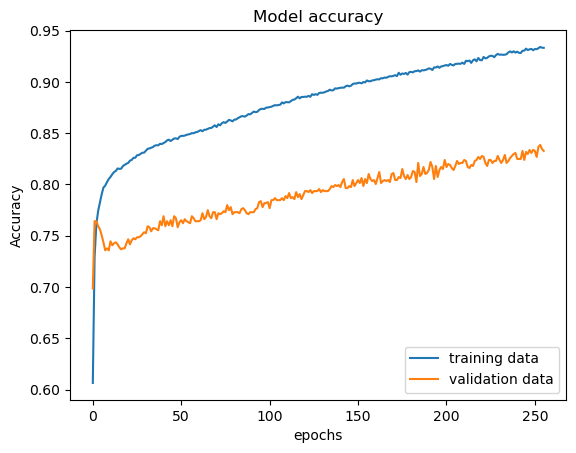

In [120]:
plt.plot(cmodelh.history['accuracy'])
plt.plot(cmodelh.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(['training data','validation data'], loc = 'lower right')
plt.title('Model accuracy')
plt.show()

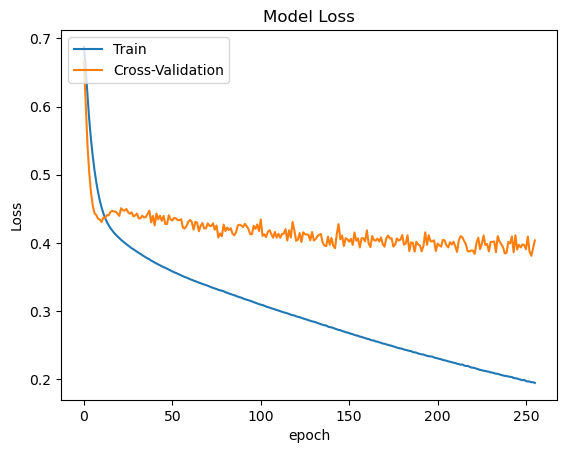

In [121]:
plt.plot(cmodelh.history['loss'])
plt.plot(cmodelh.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Cross-Validation'], loc='upper left')
plt.show()

In [122]:
scoress = model_1D.evaluate(x_train, y_train)
print(model_1D.metrics_names)
print(scoress)
print("\n%s %.2f%%" % (model_1D.metrics_names[1], scoress[1]*100))

243/243 [==============================] - 0s 2ms/step - loss: 0.1926 - accuracy: 0.9338
['loss', 'accuracy']
[0.19256605207920074, 0.9337705969810486]

accuracy 93.38%


In [123]:
scoress = model_1D.evaluate(x_test, y_test)
print("\n%s %.2f%%" % (model_1D.metrics_names[1], scoress[1]*100))

32/32 [==============================] - 0s 2ms/step - loss: 0.4036 - accuracy: 0.8327

accuracy 83.27%


In [124]:
cnnb_pred = model_1D.predict(x_test)

32/32 [==============================] - 0s 2ms/step


In [125]:
cnnb_pred=tf.squeeze(cnnb_pred)

In [126]:
cnnb_pred.shape

TensorShape([1022])

In [127]:
cnnb_acc = accuracy_score(y_test.round(), np.round(cnnb_pred))

print("Accuracy of our model is %.2f%%" % (cnnb_acc * 100))


Accuracy of our model is 83.27%


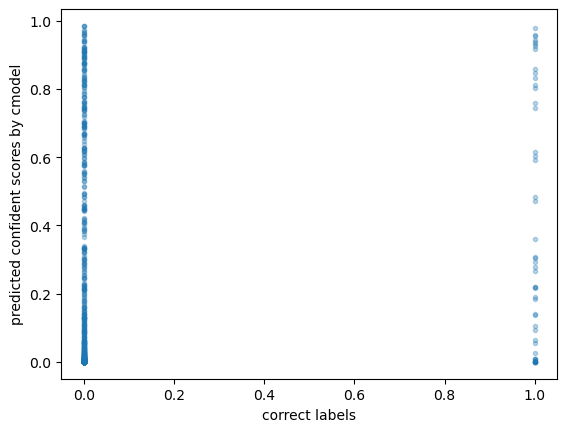

In [128]:
plt.plot(y_test, cnnb_pred, '.', alpha = 0.3)
plt.xlabel('correct labels')
plt.ylabel('predicted confident scores by cmodel')
plt.show()

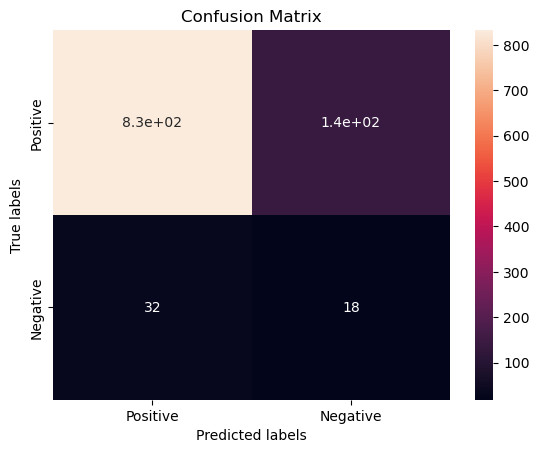

In [129]:
ax= plt.subplot()
predict_results = cnnb_pred

predict_results = (predict_results > 0.5)

cm = confusion_matrix(y_test, predict_results)

sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Positive', 'Negative']); ax.yaxis.set_ticklabels(['Positive', 'Negative']);

In [130]:
arr1=[[1,64,0,0,1,0,1,239,34.6,0]]
arr1=scale.transform(arr1)

C:\Users\Prason\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



In [131]:
pr1=model_1D.predict(arr1)
pr1

1/1 [==============================] - 0s 29ms/step


array([[[0.01358001]]], dtype=float32)

<b> LSTM Model<b>

In [132]:
import numpy as np
from keras.layers import LSTM
from keras.layers import Dropout

In [133]:
x_train.shape

(7776, 10)

In [134]:
def create_model_checkpoint_lstm(model_name, save_path = "lstm"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose = 0,
                                            save_best_only = True)

In [136]:
lst = Sequential() 

lst.add(LSTM(units=32, return_sequences=True,input_dim = len(x_t[0,:])))
lst.add(Dense(8,activation='relu'))
lst.add(Dense(4,activation='relu'))
lst.add(Dense(1, activation='sigmoid'))

lst.compile(loss='binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0025), metrics=['accuracy'])

lst_history = lst.fit(x_train,y_train, epochs=256, batch_size=10,validation_split=0.2,callbacks=[create_model_checkpoint_lstm(model_name = "modellstm")])

test_results = lst.evaluate(x_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

Epoch 1/256
607/622 [============================>.] - ETA: 0s - loss: 0.4625 - accuracy: 0.7702INFO:tensorflow:Assets written to: lstm\modellstm\assets


INFO:tensorflow:Assets written to: lstm\modellstm\assets


622/622 [==============================] - 8s 9ms/step - loss: 0.4615 - accuracy: 0.7707 - val_loss: 0.4589 - val_accuracy: 0.8728
Epoch 2/256
622/622 [==============================] - 1s 2ms/step - loss: 0.3939 - accuracy: 0.8087 - val_loss: 0.4701 - val_accuracy: 0.8689
Epoch 3/256
600/622 [===========================>..] - ETA: 0s - loss: 0.3729 - accuracy: 0.8175INFO:tensorflow:Assets written to: lstm\modellstm\assets


INFO:tensorflow:Assets written to: lstm\modellstm\assets


622/622 [==============================] - 5s 7ms/step - loss: 0.3726 - accuracy: 0.8174 - val_loss: 0.3874 - val_accuracy: 0.8882
Epoch 4/256
622/622 [==============================] - 1s 2ms/step - loss: 0.3535 - accuracy: 0.8312 - val_loss: 0.4308 - val_accuracy: 0.8548
Epoch 5/256
622/622 [==============================] - 1s 2ms/step - loss: 0.3351 - accuracy: 0.8379 - val_loss: 0.4080 - val_accuracy: 0.9036
Epoch 6/256
621/622 [============================>.] - ETA: 0s - loss: 0.3212 - accuracy: 0.8541INFO:tensorflow:Assets written to: lstm\modellstm\assets


INFO:tensorflow:Assets written to: lstm\modellstm\assets


622/622 [==============================] - 5s 7ms/step - loss: 0.3213 - accuracy: 0.8540 - val_loss: 0.3393 - val_accuracy: 0.9235
Epoch 7/256
622/622 [==============================] - 2s 4ms/step - loss: 0.3050 - accuracy: 0.8637 - val_loss: 0.4076 - val_accuracy: 0.8638
Epoch 8/256
617/622 [============================>.] - ETA: 0s - loss: 0.2909 - accuracy: 0.8689INFO:tensorflow:Assets written to: lstm\modellstm\assets


INFO:tensorflow:Assets written to: lstm\modellstm\assets


622/622 [==============================] - 5s 9ms/step - loss: 0.2919 - accuracy: 0.8686 - val_loss: 0.3305 - val_accuracy: 0.9139
Epoch 9/256
603/622 [============================>.] - ETA: 0s - loss: 0.2786 - accuracy: 0.8771INFO:tensorflow:Assets written to: lstm\modellstm\assets


INFO:tensorflow:Assets written to: lstm\modellstm\assets


622/622 [==============================] - 5s 8ms/step - loss: 0.2771 - accuracy: 0.8778 - val_loss: 0.3030 - val_accuracy: 0.9415
Epoch 10/256
622/622 [==============================] - 2s 3ms/step - loss: 0.2691 - accuracy: 0.8820 - val_loss: 0.3504 - val_accuracy: 0.9042
Epoch 11/256
620/622 [============================>.] - ETA: 0s - loss: 0.2586 - accuracy: 0.8873INFO:tensorflow:Assets written to: lstm\modellstm\assets


INFO:tensorflow:Assets written to: lstm\modellstm\assets


622/622 [==============================] - 5s 8ms/step - loss: 0.2590 - accuracy: 0.8871 - val_loss: 0.2465 - val_accuracy: 0.9524
Epoch 12/256
605/622 [============================>.] - ETA: 0s - loss: 0.2495 - accuracy: 0.8972INFO:tensorflow:Assets written to: lstm\modellstm\assets


INFO:tensorflow:Assets written to: lstm\modellstm\assets


622/622 [==============================] - 5s 8ms/step - loss: 0.2483 - accuracy: 0.8976 - val_loss: 0.1917 - val_accuracy: 0.9614
Epoch 13/256
622/622 [==============================] - 2s 3ms/step - loss: 0.2360 - accuracy: 0.9013 - val_loss: 0.2163 - val_accuracy: 0.9569
Epoch 14/256
622/622 [==============================] - 2s 3ms/step - loss: 0.2320 - accuracy: 0.9023 - val_loss: 0.2277 - val_accuracy: 0.9505
Epoch 15/256
622/622 [==============================] - 2s 3ms/step - loss: 0.2246 - accuracy: 0.9088 - val_loss: 0.2891 - val_accuracy: 0.9216
Epoch 16/256
622/622 [==============================] - 2s 3ms/step - loss: 0.2141 - accuracy: 0.9159 - val_loss: 0.2240 - val_accuracy: 0.9531
Epoch 17/256
617/622 [============================>.] - ETA: 0s - loss: 0.2082 - accuracy: 0.9139INFO:tensorflow:Assets written to: lstm\modellstm\assets


INFO:tensorflow:Assets written to: lstm\modellstm\assets


622/622 [==============================] - 5s 8ms/step - loss: 0.2086 - accuracy: 0.9137 - val_loss: 0.1809 - val_accuracy: 0.9531
Epoch 18/256
622/622 [==============================] - 1s 2ms/step - loss: 0.2019 - accuracy: 0.9190 - val_loss: 0.2987 - val_accuracy: 0.9126
Epoch 19/256
622/622 [==============================] - 1s 2ms/step - loss: 0.2026 - accuracy: 0.9177 - val_loss: 0.2621 - val_accuracy: 0.9325
Epoch 20/256
622/622 [==============================] - 1s 2ms/step - loss: 0.1915 - accuracy: 0.9244 - val_loss: 0.2920 - val_accuracy: 0.9055
Epoch 21/256
622/622 [==============================] - 1s 2ms/step - loss: 0.1861 - accuracy: 0.9278 - val_loss: 0.2309 - val_accuracy: 0.9357
Epoch 22/256
622/622 [==============================] - 1s 2ms/step - loss: 0.1814 - accuracy: 0.9294 - val_loss: 0.1960 - val_accuracy: 0.9531
Epoch 23/256
622/622 [==============================] - 2s 3ms/step - loss: 0.1793 - accuracy: 0.9299 - val_loss: 0.2189 - val_accuracy: 0.9441
Epoch

INFO:tensorflow:Assets written to: lstm\modellstm\assets


622/622 [==============================] - 5s 8ms/step - loss: 0.1631 - accuracy: 0.9407 - val_loss: 0.1504 - val_accuracy: 0.9692
Epoch 27/256
622/622 [==============================] - 1s 2ms/step - loss: 0.1649 - accuracy: 0.9367 - val_loss: 0.2300 - val_accuracy: 0.9383
Epoch 28/256
622/622 [==============================] - 2s 3ms/step - loss: 0.1570 - accuracy: 0.9395 - val_loss: 0.2036 - val_accuracy: 0.9422
Epoch 29/256
622/622 [==============================] - 2s 2ms/step - loss: 0.1540 - accuracy: 0.9439 - val_loss: 0.2116 - val_accuracy: 0.9299
Epoch 30/256
622/622 [==============================] - 2s 3ms/step - loss: 0.1495 - accuracy: 0.9439 - val_loss: 0.1986 - val_accuracy: 0.9473
Epoch 31/256
622/622 [==============================] - 2s 3ms/step - loss: 0.1480 - accuracy: 0.9468 - val_loss: 0.1881 - val_accuracy: 0.9467
Epoch 32/256
622/622 [==============================] - 2s 3ms/step - loss: 0.1412 - accuracy: 0.9469 - val_loss: 0.1804 - val_accuracy: 0.9582
Epoch

INFO:tensorflow:Assets written to: lstm\modellstm\assets


622/622 [==============================] - 5s 7ms/step - loss: 0.1340 - accuracy: 0.9519 - val_loss: 0.1482 - val_accuracy: 0.9576
Epoch 38/256
622/622 [==============================] - 1s 2ms/step - loss: 0.1309 - accuracy: 0.9519 - val_loss: 0.2088 - val_accuracy: 0.9344
Epoch 39/256
622/622 [==============================] - 2s 2ms/step - loss: 0.1286 - accuracy: 0.9527 - val_loss: 0.2485 - val_accuracy: 0.9158
Epoch 40/256
613/622 [============================>.] - ETA: 0s - loss: 0.1279 - accuracy: 0.9537INFO:tensorflow:Assets written to: lstm\modellstm\assets


INFO:tensorflow:Assets written to: lstm\modellstm\assets


622/622 [==============================] - 5s 7ms/step - loss: 0.1282 - accuracy: 0.9537 - val_loss: 0.1280 - val_accuracy: 0.9608
Epoch 41/256
622/622 [==============================] - 1s 2ms/step - loss: 0.1237 - accuracy: 0.9539 - val_loss: 0.2868 - val_accuracy: 0.9171
Epoch 42/256
622/622 [==============================] - 1s 2ms/step - loss: 0.1217 - accuracy: 0.9566 - val_loss: 0.2618 - val_accuracy: 0.9184
Epoch 43/256
622/622 [==============================] - 1s 2ms/step - loss: 0.1264 - accuracy: 0.9531 - val_loss: 0.1737 - val_accuracy: 0.9441
Epoch 44/256
622/622 [==============================] - 1s 2ms/step - loss: 0.1217 - accuracy: 0.9574 - val_loss: 0.1927 - val_accuracy: 0.9409
Epoch 45/256
622/622 [==============================] - 2s 3ms/step - loss: 0.1192 - accuracy: 0.9579 - val_loss: 0.2203 - val_accuracy: 0.9325
Epoch 46/256
622/622 [==============================] - 2s 3ms/step - loss: 0.1142 - accuracy: 0.9598 - val_loss: 0.2220 - val_accuracy: 0.9280
Epoch

INFO:tensorflow:Assets written to: lstm\modellstm\assets


622/622 [==============================] - 6s 9ms/step - loss: 0.1033 - accuracy: 0.9635 - val_loss: 0.1214 - val_accuracy: 0.9679
Epoch 59/256
622/622 [==============================] - 2s 3ms/step - loss: 0.1064 - accuracy: 0.9619 - val_loss: 0.1393 - val_accuracy: 0.9634
Epoch 60/256
622/622 [==============================] - 2s 3ms/step - loss: 0.1005 - accuracy: 0.9661 - val_loss: 0.1226 - val_accuracy: 0.9679
Epoch 61/256
622/622 [==============================] - 2s 3ms/step - loss: 0.1000 - accuracy: 0.9659 - val_loss: 0.1626 - val_accuracy: 0.9563
Epoch 62/256
622/622 [==============================] - 2s 3ms/step - loss: 0.1002 - accuracy: 0.9633 - val_loss: 0.1455 - val_accuracy: 0.9659
Epoch 63/256
622/622 [==============================] - 2s 3ms/step - loss: 0.1020 - accuracy: 0.9641 - val_loss: 0.1427 - val_accuracy: 0.9647
Epoch 64/256
622/622 [==============================] - 2s 2ms/step - loss: 0.0959 - accuracy: 0.9650 - val_loss: 0.1785 - val_accuracy: 0.9512
Epoch

INFO:tensorflow:Assets written to: lstm\modellstm\assets


622/622 [==============================] - 5s 8ms/step - loss: 0.0940 - accuracy: 0.9669 - val_loss: 0.1067 - val_accuracy: 0.9749
Epoch 78/256
622/622 [==============================] - 2s 3ms/step - loss: 0.0940 - accuracy: 0.9682 - val_loss: 0.1610 - val_accuracy: 0.9544
Epoch 79/256
622/622 [==============================] - 2s 4ms/step - loss: 0.0905 - accuracy: 0.9691 - val_loss: 0.2067 - val_accuracy: 0.9492
Epoch 80/256
622/622 [==============================] - 2s 3ms/step - loss: 0.0812 - accuracy: 0.9722 - val_loss: 0.1666 - val_accuracy: 0.9595
Epoch 81/256
622/622 [==============================] - 1s 2ms/step - loss: 0.0993 - accuracy: 0.9648 - val_loss: 0.1389 - val_accuracy: 0.9634
Epoch 82/256
622/622 [==============================] - 2s 3ms/step - loss: 0.0905 - accuracy: 0.9691 - val_loss: 0.1406 - val_accuracy: 0.9672
Epoch 83/256
622/622 [==============================] - 2s 4ms/step - loss: 0.0852 - accuracy: 0.9698 - val_loss: 0.2115 - val_accuracy: 0.9396
Epoch

Epoch 134/256
622/622 [==============================] - 2s 3ms/step - loss: 0.0619 - accuracy: 0.9786 - val_loss: 0.1216 - val_accuracy: 0.9794
Epoch 135/256
622/622 [==============================] - 2s 2ms/step - loss: 0.0723 - accuracy: 0.9756 - val_loss: 0.1456 - val_accuracy: 0.9756
Epoch 136/256
622/622 [==============================] - 2s 3ms/step - loss: 0.0622 - accuracy: 0.9783 - val_loss: 0.2039 - val_accuracy: 0.9614
Epoch 137/256
622/622 [==============================] - 2s 3ms/step - loss: 0.0618 - accuracy: 0.9793 - val_loss: 0.1494 - val_accuracy: 0.9659
Epoch 138/256
622/622 [==============================] - 2s 3ms/step - loss: 0.0695 - accuracy: 0.9749 - val_loss: 0.2246 - val_accuracy: 0.9473
Epoch 139/256
622/622 [==============================] - 2s 3ms/step - loss: 0.0698 - accuracy: 0.9768 - val_loss: 0.2193 - val_accuracy: 0.9486
Epoch 140/256
622/622 [==============================] - 2s 3ms/step - loss: 0.0645 - accuracy: 0.9764 - val_loss: 0.1787 - val_ac

INFO:tensorflow:Assets written to: lstm\modellstm\assets


622/622 [==============================] - 5s 7ms/step - loss: 0.0542 - accuracy: 0.9822 - val_loss: 0.0933 - val_accuracy: 0.9814
Epoch 177/256
622/622 [==============================] - 2s 3ms/step - loss: 0.0615 - accuracy: 0.9786 - val_loss: 0.1614 - val_accuracy: 0.9698
Epoch 178/256
622/622 [==============================] - 2s 3ms/step - loss: 0.0546 - accuracy: 0.9810 - val_loss: 0.1931 - val_accuracy: 0.9524
Epoch 179/256
622/622 [==============================] - 2s 3ms/step - loss: 0.0618 - accuracy: 0.9796 - val_loss: 0.1690 - val_accuracy: 0.9692
Epoch 180/256
622/622 [==============================] - 2s 3ms/step - loss: 0.0556 - accuracy: 0.9804 - val_loss: 0.1607 - val_accuracy: 0.9672
Epoch 181/256
622/622 [==============================] - 2s 3ms/step - loss: 0.0532 - accuracy: 0.9815 - val_loss: 0.2470 - val_accuracy: 0.9505
Epoch 182/256
622/622 [==============================] - 2s 3ms/step - loss: 0.0606 - accuracy: 0.9781 - val_loss: 0.2126 - val_accuracy: 0.9512

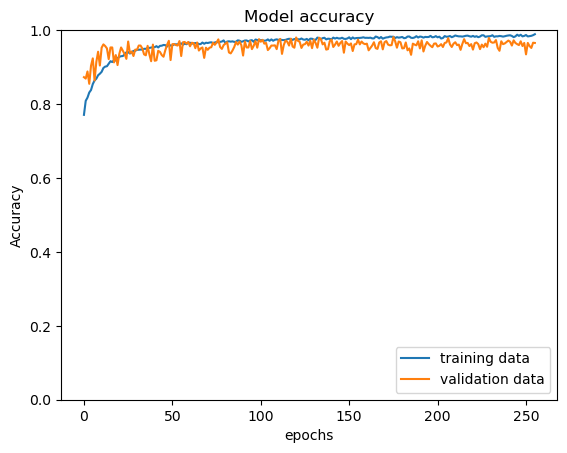

In [137]:
plt.plot(lst_history.history['accuracy'])
plt.plot(lst_history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.xlabel('epochs')
plt.legend(['training data','validation data'], loc = 'lower right')
plt.title('Model accuracy')
plt.show()

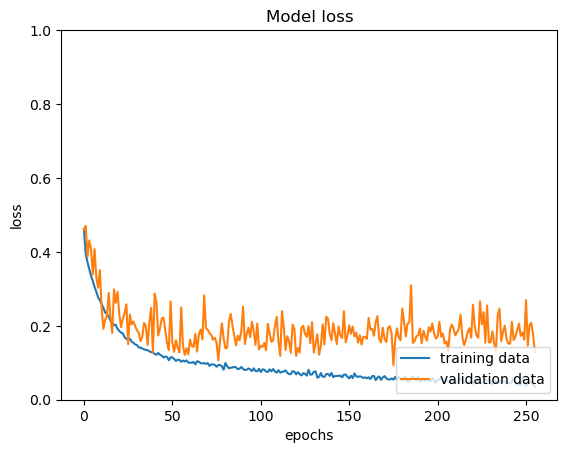

In [138]:
plt.plot(lst_history.history['loss'])
plt.plot(lst_history.history['val_loss'])
plt.ylabel('loss')
plt.ylim([0,1])
plt.xlabel('epochs')
plt.legend(['training data','validation data'], loc = 'lower right')
plt.title('Model loss')
plt.show()

In [139]:
scores = lst.evaluate(x_train, y_train)
print(lst.metrics_names)
print(scores)
print("\n%s %.2f%%" % (lst.metrics_names[1], scores[1]*100))

243/243 [==============================] - 0s 2ms/step - loss: 0.0793 - accuracy: 0.9767
['loss', 'accuracy']
[0.07932518422603607, 0.9767232537269592]

accuracy 97.67%


In [140]:
scores = lst.evaluate(x_test, y_test)
print("\n%s %.2f%%" % (lst.metrics_names[1], scores[1]*100))

32/32 [==============================] - 0s 2ms/step - loss: 0.9531 - accuracy: 0.8699

accuracy 86.99%


In [141]:
x_test
x_test.shape

TensorShape([1022, 1, 10])

In [142]:
clstm_pred = lst.predict(x_test)

32/32 [==============================] - 0s 1ms/step


In [145]:
pr1=lst.predict(tf.expand_dims(arr1, axis = 1))
pr1

1/1 [==============================] - 0s 20ms/step


array([[[1.2949585e-14]]], dtype=float32)

In [146]:
pr1.round()

array([[[0.]]], dtype=float32)

In [147]:
arr2=[[0,67,0,1,1,1,1,228,36,0]]
arr2=scale.transform(arr2)

C:\Users\Prason\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



In [148]:
pr2=lst.predict(tf.expand_dims(arr2, axis = 1))
pr2

1/1 [==============================] - 0s 23ms/step


array([[[0.0087721]]], dtype=float32)

In [149]:
lstm_acc = accuracy_score(y_test, np.round(clstm))

print("Accuracy of our model is %.2f%%" % (lstm_acc * 100))

Accuracy of our model is 86.99%


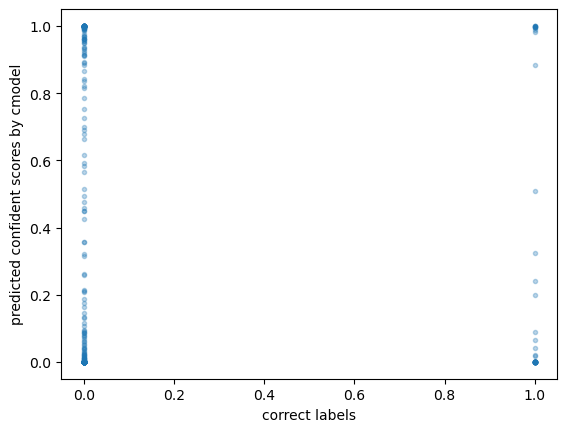

In [150]:
plt.plot(y_test, clstm, '.', alpha = 0.3)
plt.xlabel('correct labels')
plt.ylabel('predicted confident scores by cmodel')
plt.show()

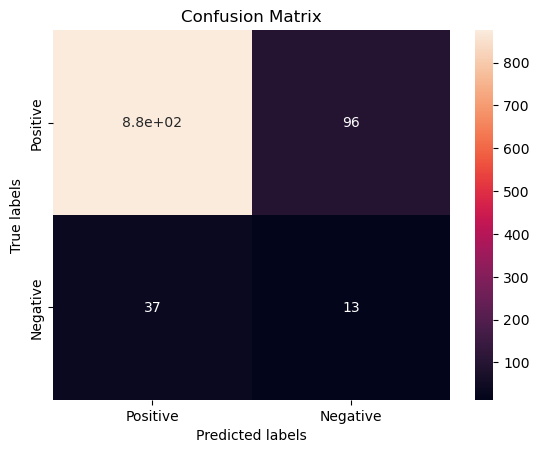

In [151]:
ax= plt.subplot()
predict_results = clstm

predict_results = (predict_results > 0.5)

cm = confusion_matrix(y_test, predict_results)

sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Positive', 'Negative']); ax.yaxis.set_ticklabels(['Positive', 'Negative']);

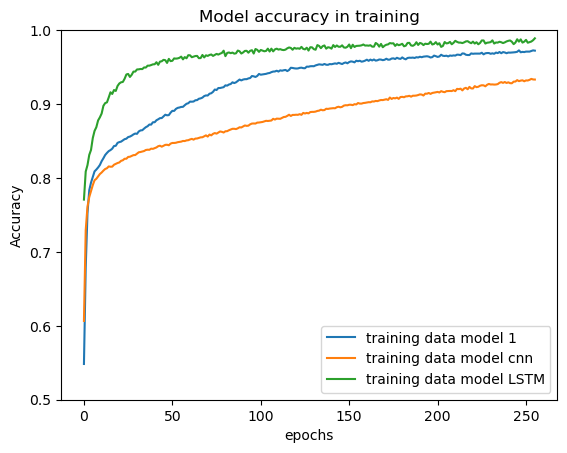

In [152]:
plt.plot(chistory.history['accuracy'])
plt.plot(cmodelh.history['accuracy'])
plt.plot(lst_history.history['accuracy'])
plt.ylabel('Accuracy')
plt.ylim([0.5,1])
plt.xlabel('epochs')
plt.legend(['training data model 1','training data model cnn','training data model LSTM'], loc = 'lower right')
plt.title('Model accuracy in training')
plt.show()

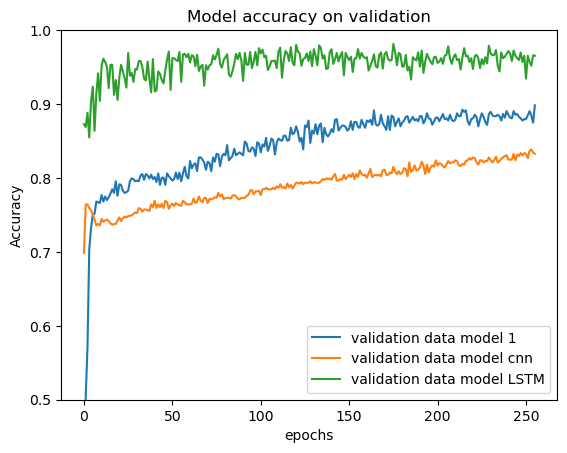

In [153]:
plt.plot(chistory.history['val_accuracy'])
plt.plot(cmodelh.history['val_accuracy'])
plt.plot(lst_history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.ylim([0.5,1])
plt.xlabel('epochs')
plt.legend(['validation data model 1','validation data model cnn','validation data model LSTM'], loc = 'lower right')
plt.title('Model accuracy on validation')
plt.show()

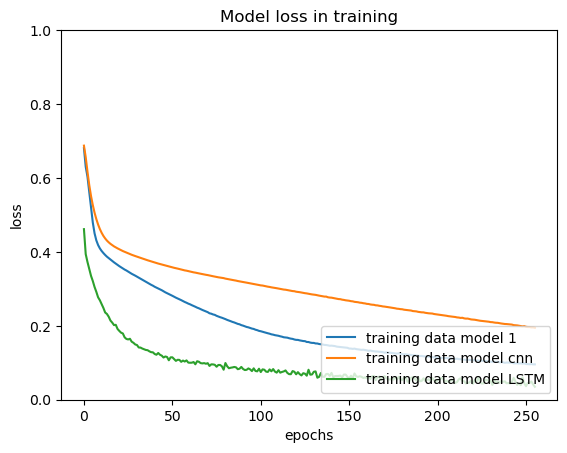

In [154]:
# print(model_1D.params)
plt.plot(chistory.history['loss'])
plt.plot(cmodelh.history['loss'])
plt.plot(lst_history.history['loss'])
plt.ylabel('loss')
plt.ylim([0,1])
plt.xlabel('epochs')
plt.legend(['training data model 1','training data model cnn','training data model LSTM'], loc = 'lower right')
plt.title('Model loss in training')
plt.show()

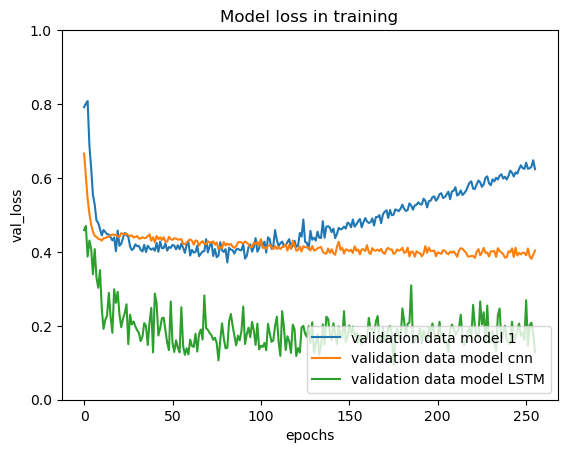

In [155]:
plt.plot(chistory.history['val_loss'])
plt.plot(cmodelh.history['val_loss'])
plt.plot(lst_history.history['val_loss'])
plt.ylabel('val_loss')
plt.ylim([0,1])
plt.xlabel('epochs')
plt.legend(['validation data model 1','validation data model cnn','validation data model LSTM'], loc = 'lower right')
plt.title('Model loss in training')
plt.show()

Text(0, 0.5, 'terms of 100')

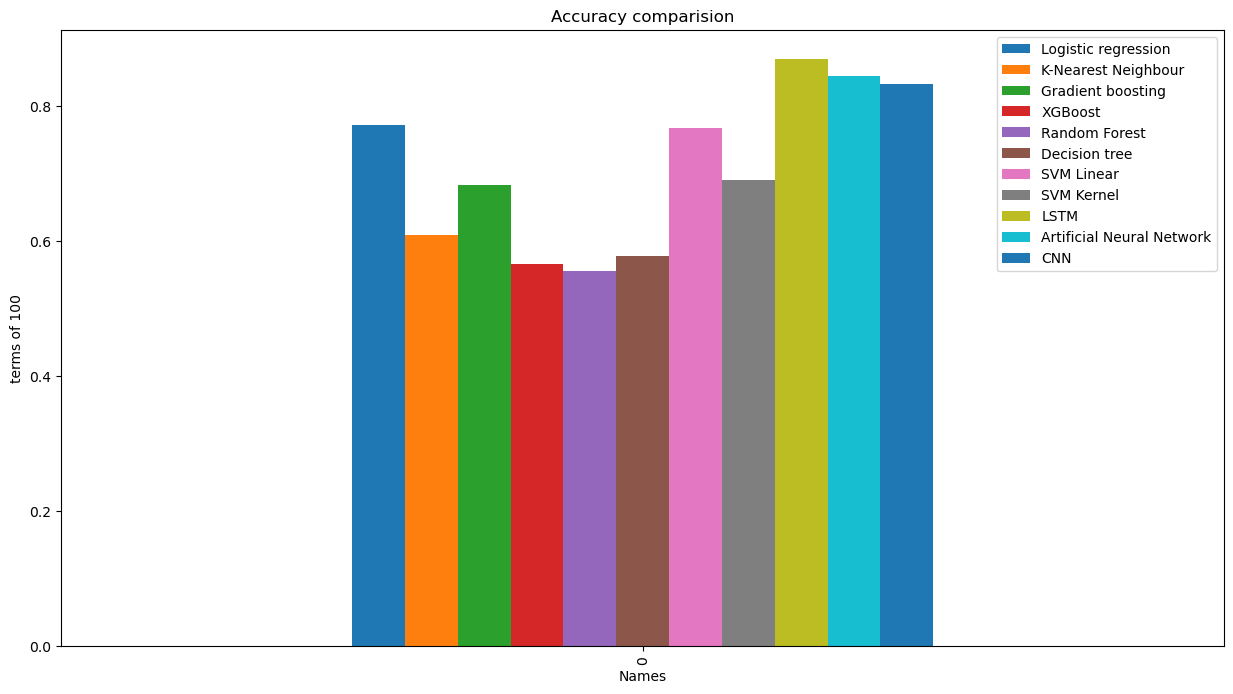

In [156]:
plotdata = pd.DataFrame({
    "Logistic regression":[acc_lr],
    "K-Nearest Neighbour":[acc_knn],
    "Gradient boosting":[acc_gbc],
    "XGBoost":[acc_xgbc],
    "Random Forest":[acc_rfc],
    "Decision tree":[acc_dect],
    "SVM Linear":[acc_lsvc],
    "SVM Kernel":[acc_svc],
    "LSTM":[lstm_acc],
    "Artificial Neural Network":[cm_acc],
    "CNN":[cnnb_acc]
})
plotdata.plot(kind="bar",figsize=(15,8))
plt.title("Accuracy comparision")
plt.xlabel("Names")
plt.ylabel("terms of 100")